In [2]:
from google.cloud import bigquery
from google.api_core.exceptions import BadRequest
import pandas as pd
import time
import numpy as np
from datetime import timedelta, datetime
import os
import geopandas
import unidecode
from google.cloud.exceptions import NotFound
import utils
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import igraph as ig

client = bigquery.Client(location="US")

## Edgelists Extractions

In [3]:
from utils import *
#def get_edgelists_coverage(client):
    
# gets locations
df_locations = get_current_locations(client)

# Starts the dates
df_locations['start_date'] = None
df_locations['end_date'] = None
df_locations['dataset_exists'] = False
df_locations['table_exists'] = False

# Sets the index
df_locations.index = df_locations.location_id

# Sets the minimum date


# Loads old coverage (to bring costs down)
df_old_coverage = get_last_graph_coverage(client)

if df_old_coverage is not None:
    for ind, row in df_old_coverage.iterrows():
        df_locations.loc[row.location_id,'start_date'] = row.start_date
        df_locations.loc[row.location_id,'end_date'] = row.end_date

# Extracts final dates
for ind, row in df_locations.iterrows():


    # extracts tables        
    tables = get_tables_from_dataset(client, row.dataset)
    if tables is None:
        # No dataset found
        continue

    # Dataset exists
    df_locations.loc[ind, 'dataset_exists'] = True

    # If table exists
    if row.location_id in tables:

        # Sets parameter
        df_locations.loc[ind, 'table_exists'] = True

        # Extracts min date (if missing)
        if pd.isna(df_locations.loc[ind,'start_date']):
            min_date = get_min_date_for_graph_table(client, row.dataset, row.location_id)
            df_locations.loc[ind,'start_date'] = min_date


        # Extracts max date
        max_date = get_max_date_for_graph_table(client, row.dataset, row.location_id, df_locations.loc[ind,'end_date'])
        df_locations.loc[ind,'end_date'] = max_date
        # Updates                


# Checks for consistency
with_error = df_locations[(df_locations.start_date.isna()) | (df_locations.end_date.isna())]
with_error = with_error[~((with_error.start_date.isna()) & (with_error.end_date.isna()))]

if with_error.shape[0] > 0:
    print(with_error)
    raise ValueError('Start Date and end date must both be none or none of them')
    
#return(df_locations)

colombia_university_rosario_campus_norte No max date found after: 2020-07-13. Will compute from start.


In [6]:
sql = """
            SELECT id1, id2, COUNT(*) as weight, SUM(contacts) as total_contacts
            FROM grafos-alcaldia-bogota.edgelists_bogota_localities.colombia_bogota_localidad_los_martires
            WHERE date >= "2020-02-03" AND date <= "2020-02-09"
            GROUP BY id1, id2


"""

df = run_simple_query(client, sql)

In [8]:
edges = df

In [10]:
sql = """
            SELECT identifier, SUM(total_transits) as weight
            FROM grafos-alcaldia-bogota.transits.hourly_transits
            WHERE location_id = "colombia_bogota_localidad_los_martires"
                  AND date >= "2020-02-03" 
                  AND date <= "2020-02-09"

            GROUP BY identifier

"""

nodes = run_simple_query(client, sql)

In [3]:
df = pd.DataFrame({'a':[1,2,3,4,5,6],'b':[1,1,1,2,2,2]})
df.index = df.b
df.loc[1]

,a,b
b,,
1,1,1
1,2,1
1,3,1


In [13]:
# Create the graph
G = ig.Graph()

# Adds the values
G.add_vertices(nodes.identifier.values)

# Adds weights
G.es['weight'] = edges.weight.values


if edges.shape[0] > 0:
    G.add_edges(edges.apply(lambda df: (df.id1, df.id2), axis = 1))



KeyboardInterrupt: 

In [15]:
e = G.evcent(weights = edges.weight.values, directed = False)
e

[2.844791962981011e-11,
 4.502503682081082e-10,
 2.844791962981011e-11,
 2.844791962981011e-11,
 2.844791962981011e-11,
 1.371212391190073e-10,
 2.844791962981011e-11,
 8.714345505388987e-11,
 5.930483791159483e-11,
 6.242807255326085e-11,
 5.743271381113778e-11,
 2.8399835300356724e-11,
 2.844791962981011e-11,
 2.903551072983485e-11,
 2.844791962981011e-11,
 2.9021410552805844e-11,
 3.417316582451164e-11,
 0.49451841011541087,
 0.145090375896301,
 2.844791962981011e-11,
 2.8397796824870734e-11,
 6.447016341683529e-11,
 2.844791962981011e-11,
 2.844791962981011e-11,
 3.925475651743517e-10,
 0.16856088294414837,
 6.119577190930183e-11,
 2.844791962981011e-11,
 0.31680643667810277,
 2.8398852442485974e-11,
 6.203999547955917e-10,
 6.410609802092604e-10,
 0.2369091326848584,
 3.685763953895083e-09,
 5.742722556165087e-11,
 8.959642536592588e-11,
 2.844791962981011e-11,
 2.844791962981011e-11,
 2.844791962981011e-11,
 0.17551113443951766,
 0.38534019252604984,
 6.119717370695756e-11,
 2.84

In [ ]:
# Exctracs the betweenness
betweenness = G.betweenness(weights = edges.weight.values, directed = False)

In [7]:
dfs = []

for ind, row in df.iterrows():
    
    location_id = row.location_id
    sql = f"""
        SELECT "{location_id}" as location_id,
        date, 
       COUNT(*) as total_contacts
        FROM
        (
          SELECT date, id1, id2
          FROM edgelists_bogota_localities.{location_id}
          WHERE date >= "2020-06-01"
          GROUP BY id1, id2, date
        )
        GROUP BY date

    """
    
    print(location_id)
    df_temp = utils.run_simple_query(client, sql)
    df_temp['name'] = row.name
    
    dfs.append(df_temp)

    
df_all = pd.concat(dfs, ignore_index = True)

colombia_bogota_localidad_usaquen
colombia_bogota_localidad_suba
colombia_bogota_localidad_tunjuelito
colombia_bogota_localidad_ciudad_bolivar
colombia_bogota_localidad_sumapaz
colombia_bogota_localidad_usme
colombia_bogota_localidad_teusaquillo
colombia_bogota_localidad_fontibon
colombia_bogota_localidad_kennedy
colombia_bogota_localidad_bosa
colombia_bogota_localidad_rafael_uribe_uribe
colombia_bogota_localidad_candelaria
colombia_bogota_localidad_los_martires
colombia_bogota_localidad_barrios_unidos
colombia_bogota_localidad_santa_fe
colombia_bogota_localidad_antonio_narino
colombia_bogota_localidad_san_cristobal
colombia_bogota_localidad_chapinero
colombia_bogota_localidad_engativa
colombia_bogota_localidad_puente_aranda


In [11]:
df_all['Nombre'] = df_all['name'].apply(lambda s: s.replace('Bogotá Localidad ',''))
df_all

,location_id,date,total_contacts,name,Nombre
0,colombia_bogota_localidad_usaquen,2020-07-01,326,Bogotá Localidad Usaquen,Usaquen
1,colombia_bogota_localidad_usaquen,2020-06-09,4297,Bogotá Localidad Usaquen,Usaquen
2,colombia_bogota_localidad_usaquen,2020-06-20,3856,Bogotá Localidad Usaquen,Usaquen
3,colombia_bogota_localidad_usaquen,2020-06-14,2982,Bogotá Localidad Usaquen,Usaquen
4,colombia_bogota_localidad_usaquen,2020-06-28,3598,Bogotá Localidad Usaquen,Usaquen
...,...,...,...,...,...
932,colombia_bogota_localidad_puente_aranda,2020-07-13,522,Bogotá Localidad Puente Aranda,Puente Aranda
933,colombia_bogota_localidad_puente_aranda,2020-06-25,3878,Bogotá Localidad Puente Aranda,Puente Aranda
934,colombia_bogota_localidad_puente_aranda,2020-06-07,3578,Bogotá Localidad Puente Aranda,Puente Aranda
935,colombia_bogota_localidad_puente_aranda,2020-07-11,501,Bogotá Localidad Puente Aranda,Puente Aranda


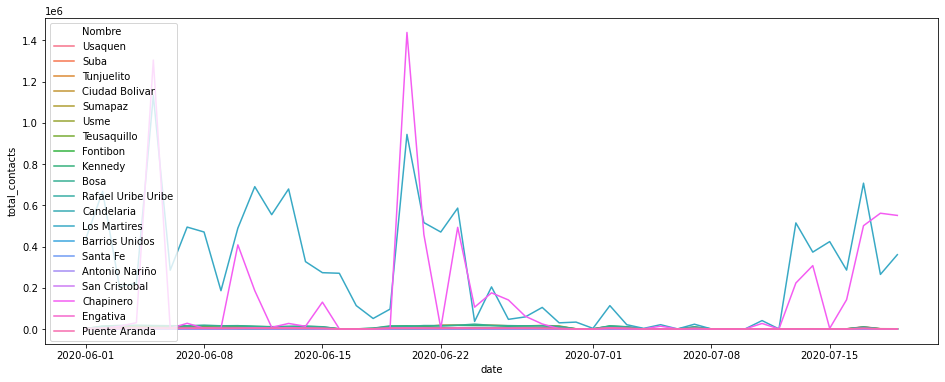

In [20]:
plt.figure(figsize=(16, 6))
df_plot1 = df_all[df_all.Nombre.isin(['Chapinero'])]
ax = sns.lineplot(x="date", y="total_contacts", hue="Nombre", data = df_all)

In [26]:
df_all[['Nombre','total_contacts']].groupby('Nombre').sum().sort_values('total_contacts')

,total_contacts
Nombre,
Sumapaz,6
Candelaria,19825
Barrios Unidos,30822
San Cristobal,40920
Santa Fe,43397
Teusaquillo,47134
Antonio Nariño,49790
Usme,93877
Puente Aranda,104651


[Text(0, 0.5, 'Número de Contactos (Millones)'), Text(0.5, 0, 'Fecha')]

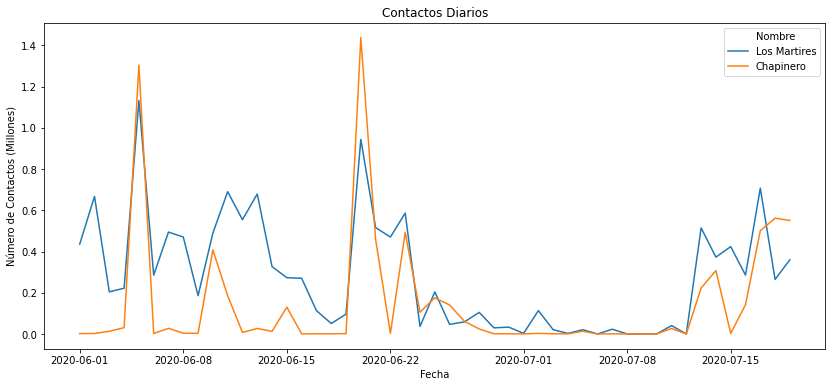

In [48]:
plt.figure(figsize=(14, 6))
grupo_1 = ['Chapinero','Los Martires']
df_plot1 = df_all[df_all.Nombre.isin(grupo_1)].copy()
df_plot1['contactos'] = df_plot1['total_contacts']/1000000
ax = sns.lineplot(x="date", y="contactos", hue="Nombre", data = df_plot1)
ax.set_title('Contactos Diarios')
ax.set(xlabel='Fecha', ylabel='Número de Contactos (Millones)')

[Text(0, 0.5, 'Número de Contactos (Miles)'), Text(0.5, 0, 'Fecha')]

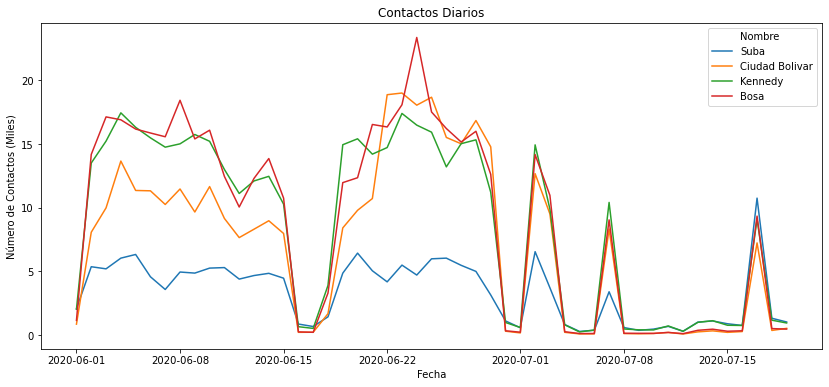

In [49]:
plt.figure(figsize=(14, 6))
grupo_2 = ['Ciudad Bolivar','Kennedy', 'Bosa', 'Suba']
df_plot1 = df_all[df_all.Nombre.isin(grupo_2)].copy()
df_plot1['contactos'] = df_plot1['total_contacts']/1000
ax = sns.lineplot(x="date", y="contactos", hue="Nombre", data = df_plot1)
ax.set_title('Contactos Diarios')
ax.set(xlabel='Fecha', ylabel='Número de Contactos (Miles)')

[Text(0, 0.5, 'Número de Contactos (Miles)'), Text(0.5, 0, 'Fecha')]

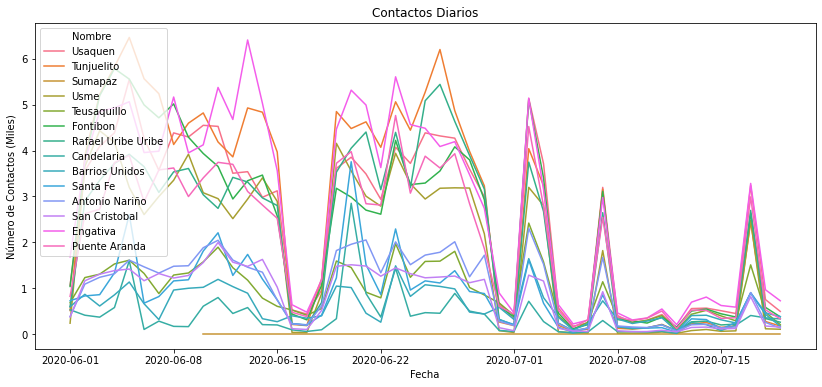

In [53]:
plt.figure(figsize=(14,6))


df_plot1 = df_all[(~df_all.Nombre.isin(grupo_1)) & (~df_all.Nombre.isin(grupo_2))].copy()
df_plot1['contactos'] = df_plot1['total_contacts']/1000
ax = sns.lineplot(x="date", y="contactos", hue="Nombre", data = df_plot1)
plt.legend(loc='upper left')
ax.set_title('Contactos Diarios')
ax.set(xlabel='Fecha', ylabel='Número de Contactos (Miles)')

In [9]:
df_locations['start_date'] = pd.to_datetime('2020-02-01')
df_locations

,location_id,start_date,end_date
location_id,,,
colombia_medellin,colombia_medellin,2020-02-01,2020-02-04
colombia_barranquilla,colombia_barranquilla,2020-02-01,2020-02-04
colombia_bogota,colombia_bogota,2020-02-01,2020-02-04
colombia_boyaca,colombia_boyaca,2020-02-01,2020-02-04
colombia_magdalena,colombia_magdalena,2020-02-01,2020-02-04
colombia_valle_del_cauca,colombia_valle_del_cauca,2020-02-01,2020-02-04
colombia_cauca,colombia_cauca,2020-02-01,2020-02-04
colombia_agglomerations_covid_friday,colombia_agglomerations_covid_friday,2020-02-01,2020-02-04
colombia_university_andes_cede_principal,colombia_university_andes_cede_principal,2020-02-01,2020-02-04


In [3]:
df_locations = utils.get_edgelists_coverage(client)

In [4]:
df_locations

,location_id,precision,dataset,start_date,end_date,dataset_exists,table_exists
location_id,,,,,,,
colombia_university_andes_cede_principal,colombia_university_andes_cede_principal,10.000000000,edgelists_universities,2020-02-01,2020-07-15,True,True
colombia_university_rosario_quinta_mutis,colombia_university_rosario_quinta_mutis,10.000000000,edgelists_universities,2020-02-01,2020-07-15,True,True
colombia_university_rosario_claustro,colombia_university_rosario_claustro,10.000000000,edgelists_universities,2020-02-01,2020-07-15,True,True
colombia_university_rosario_campus_norte,colombia_university_rosario_campus_norte,10.000000000,edgelists_universities,2020-02-01,2020-07-12,True,True
colombia_university_rosario_mederi,colombia_university_rosario_mederi,10.000000000,edgelists_universities,2020-02-01,2020-07-15,True,True
colombia_university_rosario_gsb,colombia_university_rosario_gsb,10.000000000,edgelists_universities,2020-02-01,2020-07-15,True,True
colombia_university_javeriana_cede_principal,colombia_university_javeriana_cede_principal,10.000000000,edgelists_universities,2020-02-01,2020-07-15,True,True
colombia_bogota,colombia_bogota,1000.000000000,edgelists_cities,2020-02-01,2020-07-15,True,True
colombia_barranquilla,colombia_barranquilla,1000.000000000,edgelists_cities,2020-02-01,2020-07-15,True,True


In [12]:
# Starts Client
client = bigquery.Client(location="US")

dataset_id = 'grafos-alcaldia-bogota.graphs'
dataset = client.get_dataset(dataset_id)  # Make an API request.

# Gets the tables
tables = list(client.list_tables(dataset))  # Make an API request(s).

df_locations = utils.get_current_locations(client)

# Loads old coverage
df_old_coverage = utils.get_last_graph_coverage(client)

if df_old_coverage is not None:
    # merges
    df_locations = df_locations.merge(df_old_coverage, on = 'location_id', how = 'left')
else:
    df_locations['start_date'] = None
    df_locations['end_date'] = None

# Sets index (for updating)
df_locations.index = df_locations.location_id


print('Extracting Coverage')

#Gets last coverage


# Updates all the locations
for table in tables:
    # Extracts the table id
    graph_name = table.table_id
    if graph_name in df_locations.location_id:        
        max_date = utils.get_date_range_for_graph_table(client, graph_name, df_locations.loc[graph_name,'end_date'])
        df_locations.loc[graph_name,'end_date'] = max_date

        if max_date is not None and  df_locations.loc[graph_name,'start_date'] is None:
            df_locations.loc[graph_name,'start_date'] =  utils.global_min_date.date()

Extracting Coverage


In [19]:
df_locations.start_date = pd.to_datetime('2020-02-01')
df_locations.end_date = pd.to_datetime('2020-07-05')

In [20]:
df_locations

,location_id,start_date,end_date
location_id,,,
colombia_medellin,colombia_medellin,2020-02-01,2020-07-05
colombia_barranquilla,colombia_barranquilla,2020-02-01,2020-07-05
colombia_bogota,colombia_bogota,2020-02-01,2020-07-05
colombia_boyaca,colombia_boyaca,2020-02-01,2020-07-05
colombia_magdalena,colombia_magdalena,2020-02-01,2020-07-05
colombia_valle_del_cauca,colombia_valle_del_cauca,2020-02-01,2020-07-05
colombia_cauca,colombia_cauca,2020-02-01,2020-07-05
colombia_agglomerations_covid_friday,colombia_agglomerations_covid_friday,2020-02-01,2020-07-05
colombia_university_andes_cede_principal,colombia_university_andes_cede_principal,2020-02-01,2020-07-05


In [22]:
utils.refresh_graphs_coverage(client, df_locations)

In [29]:
# Starts Client
client = bigquery.Client(location="US")

dataset_id = 'grafos-alcaldia-bogota.graphs'
dataset = client.get_dataset(dataset_id)  # Make an API request.

# Gets the tables
tables = list(client.list_tables(dataset))  # Make an API request(s).

df_locations = utils.get_current_locations(client)

# Loads old coverage
df_old_coverage = utils.get_last_graph_coverage(client)

if df_old_coverage is not None:
    # merges
    df_locations = df_locations.merge(df_old_coverage, on = 'location_id', how = 'left')
else:
    df_locations['start_date'] = None
    df_locations['end_date'] = None

# Sets index (for updating)
df_locations.index = df_locations.location_id


print('Extracting Coverage')

#Gets last coverage


# Updates all the locations
for table in tables:
    # Extracts the table id
    graph_name = table.table_id
    if graph_name in df_locations.location_id:        
        max_date = utils.get_date_range_for_graph_table(client, graph_name, df_locations.loc[graph_name,'end_date'])
        df_locations.loc[graph_name,'end_date'] = max_date

        if max_date is not None and  df_locations.loc[graph_name,'start_date'] is None:
            df_locations.loc[graph_name,'start_date'] =  utils.global_min_date.date()

# Iterates over the missing places 

today = pd.to_datetime(datetime.today())

#DEBUG
#today = pd.to_datetime("2020-07-10")

# Filters out
selected = df_locations[(df_locations.end_date.isna()) | (df_locations.end_date + timedelta(days = 1) < today)]


start_time = time.time()
print('Started')


if selected.shape[0] == 0:
    print('   No places found.')

total_locations = selected.shape[0]
i = 0
for ind, row in selected.iterrows():
    # Counter
    i += 1

    # Location 
    location_id = row.location_id

    print(f'   Excecuting: {location_id} ({i} of {total_locations})')

    # Checks if the table exists (if the end_date is null)
    if row.start_date is None:
        print(f"      No table found for {location_id}, creating table...")
        utils.add_graph_table(client, location_id)
        df_locations.loc[ind, 'start_date'] = utils.global_min_date.date()

    curent_date = utils.global_min_date.date()
    if row.end_date is not None:
        curent_date = (pd.to_datetime(row.end_date) + timedelta(days = 1))

    final_date = today.date() - timedelta(days = 1)

    while curent_date < final_date:

        print(f"      Computing {curent_date}")

        utils.add_edglists_to_graph(client, location_id, curent_date.strftime( utils.date_format))

        #updates
        curent_date = curent_date + timedelta(days = 1)

    print(f'   Current Time: {np.round((time.time() - start_time)/60,2)} minutes')
    print()

    #updates the value
    df_locations.loc[ind, 'end_date'] = final_date - timedelta(days = 14) # Sets back 14 days, to avoid this script to run with transit failing

print('Saves coverage')
utils.refresh_graphs_coverage(client, df_locations)
print()
print('-------------------')
print(f'Total Time: {np.round((time.time() - start_time)/60,2)} minutes')

Extracting Coverage
Started
   Excecuting: colombia_university_andes_cede_principal (1 of 2)
   Current Time: 0.0 minutes

   Excecuting: colombia_university_rosario_campus_norte (2 of 2)
      Computing 2020-07-13 00:00:00
   Current Time: 0.1 minutes

Saves coverage

-------------------
Total Time: 0.29 minutes


In [26]:
today

Timestamp('2020-07-15 19:10:55.940267')

In [25]:
final_date

Timestamp('2020-07-14 19:10:55.940267')

In [24]:
df_locations

,location_id,start_date,end_date
location_id,,,
colombia_medellin,colombia_medellin,2020-02-01,2020-07-14
colombia_barranquilla,colombia_barranquilla,2020-02-01,2020-07-14
colombia_bogota,colombia_bogota,2020-02-01,2020-07-14
colombia_boyaca,colombia_boyaca,2020-02-01,2020-07-14
colombia_magdalena,colombia_magdalena,2020-02-01,2020-07-14
colombia_valle_del_cauca,colombia_valle_del_cauca,2020-02-01,2020-07-14
colombia_cauca,colombia_cauca,2020-02-01,2020-07-14
colombia_agglomerations_covid_friday,colombia_agglomerations_covid_friday,2020-02-01,2020-07-14
colombia_university_andes_cede_principal,colombia_university_andes_cede_principal,2020-02-01,2020-06-30 19:10:55.940267


In [14]:
def refresh_graphs_coverage(client, df_coverage):
    '''
    Updates the graphs coverage
    '''
        
    # resets index
    df_coverage = df_coverage.reset_index(drop = True)
    
    # substracts one day for safety
    df_coverage.end_date = df_coverage.end_date - timedelta(days = 1)
    
    table_id = 'grafos-alcaldia-bogota.coverage_dates.graphs_coverage'
    # deletes the table
    client.delete_table(table_id, not_found_ok=True)
    
    # Since string columns use the "object" dtype, pass in a (partial) schema
    # to ensure the correct BigQuery data type.
    job_config = bigquery.LoadJobConfig(schema=[
        bigquery.SchemaField("location_id", "STRING"),
        bigquery.SchemaField("start_date", "DATE"),
        bigquery.SchemaField("end_date", "DATE"),
    ])

    job = client.load_table_from_dataframe(
        df_coverage, table_id, job_config=job_config
    )

    # Wait for the load job to complete.
    job.result()

In [10]:
utils.refresh_graphs_coverage(client, df_locations)

In [31]:
df_coverage['end_date'] = pd.to_datetime('2020-03-15')

In [26]:
df_locations

,location_id,start_date,end_date
location_id,,,
colombia_medellin,colombia_medellin,2020-02-01,2020-03-05
colombia_barranquilla,colombia_barranquilla,2020-02-01,2020-03-05
colombia_bogota,colombia_bogota,2020-02-01,2020-03-05
colombia_boyaca,colombia_boyaca,2020-02-01,2020-03-05
colombia_magdalena,colombia_magdalena,2020-02-01,2020-03-05
colombia_valle_del_cauca,colombia_valle_del_cauca,2020-02-01,2020-03-05
colombia_cauca,colombia_cauca,2020-02-01,2020-03-05
colombia_agglomerations_covid_friday,colombia_agglomerations_covid_friday,2020-02-01,2020-03-05
colombia_university_andes_cede_principal,colombia_university_andes_cede_principal,2020-02-01,2020-03-05


In [14]:
#def get_graphs_coverage(client):
#    '''
#    Gets the date coverage for each graph in the graphs dataset
#    '''
    
# Gets the dataset for the table extraction


dataset_id = 'grafos-alcaldia-bogota.graphs'
dataset = client.get_dataset(dataset_id)  # Make an API request.

# Gets the tables
tables = list(client.list_tables(dataset))  # Make an API request(s).

df_locations = utils.get_current_locations(client)

# Loads old coverage
df_old_coverage = utils.get_last_graph_coverage(client)

if df_old_coverage is not None:
    # merges
    df_locations = df_locations.merge(df_old_coverage, on = 'location_id', how = 'left')
else:
    df_locations['start_date'] = None
    df_locations['end_date'] = None

# Sets index (for updating)
df_locations.index = df_locations.location_id


print('Extracting Coverage')

#Gets last coverage


# Updates all the locations
for table in tables:
    # Extracts the table id
    graph_name = table.table_id
    if graph_name in df_locations.location_id:        
        max_date = utils.get_date_range_for_graph_table(client, graph_name, df_locations.loc[graph_name,'end_date'])
        df_locations.loc[graph_name,'end_date'] = max_date
        
# Iterates over the missing places 

today = pd.to_datetime(datetime.today())

#DEBUG
today = pd.to_datetime("2020-06-01")

# Filters out
selected = df_locations[(df_locations.end_date.isna()) | (df_locations.end_date + timedelta(days = 1) < today)]


start_time = time.time()
print('Started')


if selected.shape[0] == 0:
    print('   No places found.')

total_locations = selected.shape[0]
i = 0
for ind, row in selected.iterrows():
    # Counter
    i += 1
    
    # Location 
    location_id = row.location_id
    
    print(f'   Excecuting: {location_id} ({i} of {total_locations})')
    
    # Checks if the table exists (if the end_date is null)
    if row.start_date is None:
        print(f"      No table found for {location_id}, creating table...")
        utils.add_graph_table(client, location_id)
        
    curent_date = utils.global_min_date
    if row.end_date is not None:
        curent_date = (pd.to_datetime(row.end_date) + timedelta(days = 1))
    
    final_date = today
    
    while curent_date < final_date:
    
        print(f"      Computing {curent_date}")

        utils.add_edglists_to_graph(client, location_id, curent_date.strftime( utils.date_format))

        #updates
        curent_date = curent_date + timedelta(days = 1)
        
    print(f'   Current Time: {np.round((time.time() - start_time)/60,2)} minutes')
    print()

    #updates the value
    df_locations.loc[ind, 'end_date'] = final_date - timedelta(days = 1) # Sets back 15 days, to avoid this script to run with transit failing

print('Saves coverage')
utils.refresh_graphs_coverage(client, df_locations)
print()
print('-------------------')
print(f'Total Time: {np.round((time.time() - start_time)/60,2)} minutes')
    

Extracting Coverage
Started
   Excecuting: colombia_medellin (1 of 15)
      Computing 2020-04-15 00:00:00
      Computing 2020-04-16 00:00:00
      Computing 2020-04-17 00:00:00
      Computing 2020-04-18 00:00:00
      Computing 2020-04-19 00:00:00
      Computing 2020-04-20 00:00:00
      Computing 2020-04-21 00:00:00
      Computing 2020-04-22 00:00:00
      Computing 2020-04-23 00:00:00
      Computing 2020-04-24 00:00:00
      Computing 2020-04-25 00:00:00
      Computing 2020-04-26 00:00:00
      Computing 2020-04-27 00:00:00
      Computing 2020-04-28 00:00:00
      Computing 2020-04-29 00:00:00
      Computing 2020-04-30 00:00:00
      Computing 2020-05-01 00:00:00
      Computing 2020-05-02 00:00:00
      Computing 2020-05-03 00:00:00
      Computing 2020-05-04 00:00:00
      Computing 2020-05-05 00:00:00
      Computing 2020-05-06 00:00:00
      Computing 2020-05-07 00:00:00
      Computing 2020-05-08 00:00:00
      Computing 2020-05-09 00:00:00
      Computing 2020-05-10 00

# Add University

,id,university,campus
id,,,
rosario_gsb,rosario_gsb,Rosario,GSB
rosario_mederi,rosario_mederi,Rosario,Mederi
rosario_claustro,rosario_claustro,Rosario,Claustro
rosario_campus_norte,rosario_campus_norte,Rosario,Campus Norte
rosario_quinta_mutis,rosario_quinta_mutis,Rosario,Quinta Mutis
andes_cede_principal,andes_cede_principal,Andes,Cede Principal
javeriana_cede_principal,javeriana_cede_principal,Javeriana,Cede Principal


In [27]:
def get_unis(client):
    '''
        Get Universities
    '''
    
    job_config = bigquery.QueryJobConfig()
        
    
    sql = f"""
        SELECT id, university, campus
        FROM grafos-alcaldia-bogota.poligons_and_points.universities
        """
    
    query_job = client.query(sql, job_config=job_config) 

    # Return the results as a pandas DataFrame
    df = query_job.to_dataframe()
    
    return(df)
    

def load_university(client, uni_id, precision = 1000):
    '''
    Method that loads a university to the locations table
    
    precision is in meters
    '''
    
    print(f'Adding: {uni_id}')
    
    # loads the unis
    df_unis = get_unis(client)
    df_unis.index = df_unis['id']
    
    # Cerates name
    final_name = "University {} {}".format(df_unis.loc[uni_id].university, df_unis.loc[uni_id].campus)
    
    # Country
    country = "Colombia"
    
    final_id = 'colombia_university_{}'.format(uni_id)
    
    # Inserts Geometry
    query = f"""
            INSERT INTO grafos-alcaldia-bogota.geo.locations_geometries (location_id, country, name, geometry)
            SELECT "{final_id}" as location_id,
                   "{country}" as country,
                    "{final_name}" as name,
                   geometry
            FROM grafos-alcaldia-bogota.poligons_and_points.universities
            WHERE id = "{uni_id}"
    """
    
    print('   Adding Geometry')
    query_job = client.query(query, job_config= bigquery.QueryJobConfig()) 
    query_job.result()
    
    
    print('   Adding Province Codes')
    
    query = f"""
            SELECT
              "{final_id}" as location_id,
              "{country}" as country,
              "{final_name}" as name,
              province_short as code_depto
            FROM
              servinf-unacast-prod.unacasttest.unacast_positions_partitioned AS unacast
            WHERE
              date = "2020-06-26"
              AND ST_DWithin(ST_GeogPoint(unacast.device_lon,
                  unacast.device_lat),
                (SELECT geometry FROM grafos-alcaldia-bogota.geo.locations_geometries WHERE location_id = "{final_id}"),
                1000)
            GROUP BY  province_short
    """
    
    job_config= bigquery.QueryJobConfig(destination= "grafos-alcaldia-bogota.geo.locations_geo_codes",
                                        write_disposition = 'WRITE_APPEND')
    query_job = client.query(query, job_config= job_config) 
    query_job.result()
    
    print('Done')
    
    return('OK')

In [34]:
uni_id = "javeriana_cede_principal"
load_university(client, uni_id)

Adding: javeriana_cede_principal
   Adding Geometry
   Adding Province Codes
Done


'OK'

# Updates Transits

In [7]:
# Precision
precision = 1000 #meters

# Gets the coverage
client = bigquery.Client(location="US")
df_transits = utils.get_transits_coverage(client)

today = pd.to_datetime(datetime.today())

# Filters out
selected = df_transits[(df_transits.max_date.isna()) | (df_transits.max_date + timedelta(days = 1) < today)]

start_time = time.time()
print('Started')

total_locations = selected.shape[0]
i = 0
for ind, row in selected.iterrows():
    # Counter
    i += 1
    
    # Start date
    start_date = utils.global_min_date.strftime(utils.date_format)
    if row.max_date is not None:
        start_date = (pd.to_datetime(row.max_date) + timedelta(days = 1)).strftime(utils.date_format)
    
    # Today
    end_date = today.strftime(utils.date_format)
    
    # Location 
    location_id = row.location_id
    
    print(f'   Excecuting: {location_id} ({i} of {total_locations})')
    
    #utils.compute_transits(client, location_id, start_date, end_date, precision = precision, ident = '      ')
    
    print(f'   Current Time: {np.round((time.time() - start_time)/60,2)} minutes')
    print()

print()
print('-------------------')
print(f'Total Time: {np.round((time.time() - start_time)/60,2)} minutes')

Started

-------------------
Total Time: 0.0 minutes


In [2]:
client = bigquery.Client(location="US")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: grafos-alcaldia-bogota


In [10]:
pacho = "POLYGON ((-74.21496636005791 5.297866095390341, -74.21321945508369 5.297249287824066, -74.21067548565208 5.297590061127317, -74.21046346641523 5.297514368821176, -74.20988524136656 5.296094751572904, -74.20999631534882 5.293340029726654, -74.20897810757057 5.290959691790516, -74.20779019612843 5.288580515133092, -74.20745102611298 5.287050069061609, -74.20762053376563 5.286030444658101, -74.20769469498129 5.285707905899963, -74.20812866037453 5.283820480747984, -74.20846770769957 5.28194965633466, -74.20897572365419 5.279229895287775, -74.20931448673517 5.276000373234922, -74.20948283798272 5.272090402965114, -74.20829528512388 5.268519819392455, -74.20642925777523 5.266650568720427, -74.20473294880142 5.264781280144962, -74.20367161318117 5.262045468081615, -74.20367031710879 5.26204213331904, -74.2035455357927 5.261720482386628, -74.20320560075048 5.259000885933832, -74.20286590369329 5.25458121977966, -74.20303458514654 5.252200635677934, -74.20320389588257 5.25016142302428, -74.20371241411348 5.247101421138264, -74.20303272155151 5.242511135003838, -74.2021846986726 5.239111152852075, -74.20167505173765 5.236220901873365, -74.20201393184522 5.23350117438881, -74.20235227821868 5.230951001386882, -74.2014896880974 5.227926301566395, -74.20224888694467 5.226827441718671, -74.20269055492547 5.225086588931908, -74.20269006785992 5.222536479987586, -74.20285937380591 5.220496135300039, -74.20370692537055 5.218626344280772, -74.2037065321514 5.21658602874076, -74.20353638298292 5.214205508942544, -74.20370568482869 5.212166293068605, -74.20370539022653 5.210635774651273, -74.20285697542339 5.207916272847096, -74.20200876055819 5.206216362076162, -74.20149930376517 5.204176142368041, -74.20183829974015 5.202136893756306, -74.20234632271919 5.199586685126985, -74.20251536727612 5.196186506148632, -74.2026847648422 5.194655955067176, -74.20299986385476 5.191491992178806, -74.20297562224111 5.191488605896251, -74.2028324270894 5.191466027905729, -74.20263793400056 5.191466063755074, -74.20244344537194 5.191484187212184, -74.2023121221838 5.19162663660994, -74.20222025292118 5.191741953018832, -74.20208892825553 5.191891187282136, -74.20199762797759 5.192033628720045, -74.20185446639027 5.192182866173494, -74.20175752478725 5.1923151381051, -74.201597450767 5.192464377020691, -74.20144864862243 5.192612482413947, -74.20131675263529 5.192710849247824, -74.20117413483435 5.192768524969654, -74.20100219619955 5.192785513209593, -74.20093398096985 5.192774223788831, -74.20084208629518 5.192751631706304, -74.20056188156836 5.192637516666636, -74.20042995902342 5.192585544607342, -74.20032171601211 5.192568610174436, -74.20015539826937 5.192495165976998, -74.1999840093997 5.192448853318398, -74.19981205792989 5.192403670183609, -74.19968758471788 5.192364150447544, -74.19959500512682 5.192334758933753, -74.19928612921606 5.192638885310999, -74.19904037483141 5.192851439721602, -74.19894850259081 5.192959970757915, -74.1988284624462 5.193155547210842, -74.19878844757054 5.193217725951205, -74.19870277499081 5.19330930026676, -74.19850268114669 5.193504891116666, -74.19837137069486 5.193740034275122, -74.1983200866069 5.193837253787409, -74.19821695932322 5.194037348355408, -74.19809691802416 5.19423857740869, -74.1979768741172 5.194421716961699, -74.19793686465842 5.194513285172834, -74.197782457008 5.194851294144046, -74.19779996266649 5.195011803729358, -74.197840065956 5.195428901251455, -74.19790889155502 5.19570356803781, -74.19794894895254 5.195864074214641, -74.19794335325018 5.196093538731789, -74.19777773991459 5.196803441235398, -74.19769208778673 5.197020486971955, -74.19759516356011 5.197238666112926, -74.19749823263729 5.197421803886884, -74.1973607187292 5.197651294373331, -74.1972694417215 5.197931641630273, -74.19720070124683 5.198131728595427, -74.19714377135408 5.198178086219163, -74.197046255952 5.198252707068995, -74.19691491574508 5.198332987043554, -74.19675484226076 5.198499181162107, -74.19667480740137 5.198602058710948, -74.19657729309962 5.198687984056435, -74.19652037287216 5.198786335757252, -74.19642908404842 5.198992079630331, -74.19648605321071 5.199163887264526, -74.19652608825592 5.199220396212786, -74.19664111059888 5.199317586893781, -74.19679560510443 5.199461117814635, -74.19686383397695 5.199541360000498, -74.1968869565743 5.199597874837479, -74.19691010343972 5.19976403609281, -74.19682443590114 5.199907607004289, -74.19678443216651 5.200027433387258, -74.19675006932685 5.20016534365535, -74.19675571656643 5.200221860895961, -74.19675573555529 5.200337159145826, -74.19674447670181 5.20042307091216, -74.19667009298274 5.200594898822578, -74.19661316278062 5.200645776961148, -74.19652128110961 5.200697790250817, -74.19622983709218 5.200789402144554, -74.19614979202952 5.200830110394575, -74.19594968074891 5.200944313195069, -74.19589782564051 5.201007621632121, -74.19586402963139 5.201168141783127, -74.19585842013808 5.20132300209723, -74.19583533005481 5.201459781641965, -74.19583542588016 5.201992185891027, -74.1958529281181 5.202135740009452, -74.19586423225341 5.202296248973832, -74.19585297023607 5.202370856157475, -74.19576165405805 5.202438694360319, -74.19567597213191 5.202479402706731, -74.19556153413873 5.202514463693562, -74.19543525455778 5.202520140068819, -74.19533265799838 5.202559721167654, -74.19524699934829 5.202725900998511, -74.19520078695621 5.202823120213864, -74.19514950803394 5.202949730795507, -74.19506383783047 5.20306391376158, -74.19497816159922 5.203155487586095, -74.1948637352841 5.203230113974672, -74.19472056366889 5.203362391650495, -74.19453795944416 5.203648408222699, -74.19448047409576 5.203758064411701, -74.19452110476459 5.203986390826158, -74.19455551382451 5.204094899582965, -74.19457807569695 5.204158197702558, -74.1946237718583 5.204341309424863, -74.19464126219026 5.204421563071347, -74.1946413462601 5.204890664985958, -74.1945387748995 5.205073802450873, -74.19448692878331 5.205183455782155, -74.19422425496894 5.205389231133186, -74.19405232898761 5.205504559402188, -74.19402415195916 5.205567863307233, -74.19386412798667 5.206036995717516, -74.19374973000288 5.206289089380393, -74.19368098575667 5.206489175954977, -74.19358969826438 5.206713004364786, -74.1935440489609 5.206804574237283, -74.19339525533479 5.20702275866917, -74.19329268327779 5.20720589774322, -74.19335527306409 5.207280491295683, -74.19338967673578 5.207359609684738, -74.19339589931043 5.207480558610946, -74.19335591481297 5.207721333935639, -74.19328153698767 5.207949684268276, -74.19309895305094 5.208362298704131, -74.19298456707331 5.208688996380567, -74.19281891257337 5.209210124574001, -74.19265885440885 5.209496135569823, -74.19267013494097 5.209525523022061, -74.19241534103134 5.209679297556528, -74.19162732026227 5.210345221992852, -74.19150284301311 5.21101103012937, -74.19129545701806 5.211468865892049, -74.19100516319196 5.211718729207252, -74.19025824190824 5.212093010129836, -74.18959422216992 5.212633438314164, -74.18913762934747 5.212966974767205, -74.18872274891609 5.213258679074473, -74.18834957187906 5.213466729583903, -74.18789287314262 5.21317517184415, -74.18710467013298 5.212801151264701, -74.18664798778045 5.212593240587323, -74.1862741991951 5.212509652806928, -74.18594272671049 5.212634050306887, -74.18507120282359 5.212967651623089, -74.18448998307966 5.213092087406767, -74.18428252555576 5.213133944397522, -74.18357723598625 5.213009718017054, -74.18332806500901 5.213092274910609, -74.1832035073717 5.213300282334269, -74.18295492609407 5.213550133184725, -74.1828303691472 5.213758139631353, -74.18254003810456 5.213800010830348, -74.18212513925297 5.21400806465798, -74.1815439554331 5.214382307776382, -74.18137822863282 5.214507805825306, -74.18083869210861 5.214424243088393, -74.18042374085934 5.214299967226953, -74.1799253620685 5.21421639786736, -74.17938585202518 5.214300128086201, -74.17909553865638 5.214466337996868, -74.17892982858331 5.214716173894526, -74.17888816826427 5.215090331863414, -74.17888819892606 5.215298321067415, -74.17863959866548 5.215422699588583, -74.17843156860727 5.215422731207397, -74.17822411474268 5.215506409772723, -74.17776806690607 5.215756290908644, -74.17743601968587 5.215838857803654, -74.17731141457767 5.215756359950154, -74.17718683643874 5.215838895553137, -74.17697939543473 5.216006220819807, -74.17677195981204 5.2162142410153, -74.1765228183322 5.216504781744233, -74.17606676075707 5.216712838111187, -74.17561012900245 5.216838378401345, -74.17555001560569 5.216898386722709, -74.17548555600894 5.216962737227036, -74.17502952340348 5.217336955798191, -74.17473867228635 5.217712281589166, -74.17444840440584 5.218210815281123, -74.17415813074598 5.218668656556489, -74.1740752996988 5.218960305615911, -74.17403359717639 5.219084654129154, -74.17399192839548 5.21941811678697, -74.17395083324119 5.219834097900297, -74.17386800726385 5.220166440112112, -74.17378461833465 5.220498779684512, -74.17378469640505 5.221040226024114, -74.17382644439822 5.221248207919844, -74.17395108031077 5.221539825093922, -74.17403399625246 5.221830318286452, -74.1739923026425 5.221996487625449, -74.17399232092336 5.222121960082211, -74.17407578901081 5.222329934635255, -74.17407581173272 5.222496100273164, -74.17403411809292 5.222662268707742, -74.17386841577523 5.22299575218983, -74.17374387206122 5.223328098049381, -74.17378506919917 5.223619728920379, -74.17390971819059 5.223993861895812, -74.17395148544796 5.22432618403262, -74.17403441475287 5.224701453746086, -74.17403449383355 5.225241769643159, -74.17407631510943 5.225949376002009, -74.17411753164382 5.226365344372612, -74.174034758806 5.227072967167842, -74.1740348551595 5.227737624188222, -74.17420066008107 5.228112882878726, -74.17436704058412 5.228569525970399, -74.17452720289579 5.22888713676446, -74.17451874771416 5.228914266855541, -74.1744753463263 5.228969660595696, -74.17437952317125 5.229098538028834, -74.17423014511181 5.229259070339806, -74.1742183058973 5.229271507999934, -74.17405258517886 5.229471605598018, -74.17402950542049 5.229706727077943, -74.17394947775924 5.229918116919789, -74.17388690466082 5.229958819715241, -74.17388691157659 5.230004035256242, -74.17385816599717 5.230050382869295, -74.17382941332941 5.230050387287084, -74.17381814731402 5.23010690731486, -74.17362930092681 5.230250492769924, -74.17318336635464 5.230353419758811, -74.17306893675618 5.230485690931733, -74.172886294132 5.230633793971715, -74.17264050067431 5.230737824081929, -74.17205704235373 5.231092842742449, -74.17177687920882 5.231356259302488, -74.17154295681199 5.231681838931632, -74.17129098744498 5.231974639658073, -74.17129098990891 5.231997246976822, -74.17127407561949 5.231997250411796, -74.17123970043262 5.232094465217126, -74.17100519699062 5.232301357214035, -74.17054800591654 5.232564796905242, -74.17024526674821 5.232643964682198, -74.17020523759366 5.232632666040516, -74.16992503969787 5.232650792375216, -74.16982751069551 5.232684716825306, -74.16960482419415 5.232724310591792, -74.1694159677247 5.232817029233183, -74.16926150862061 5.232925564289511, -74.1690213661596 5.233136976940799, -74.16886691674748 5.233325767884895, -74.1684553886484 5.233577897558503, -74.16817519704361 5.233624282267381, -74.16803256593596 5.23367516755189, -74.16776928417265 5.2337158969027, -74.16768923300415 5.233749820314198, -74.16703750272268 5.233755559280502, -74.16647708544656 5.23363581578712, -74.16603111364796 5.233493449213048, -74.16548195184761 5.233200757219593, -74.16531055292842 5.233138611124298, -74.16510477623275 5.233155591798319, -74.1649159056125 5.233126226844973, -74.16481836438146 5.233081024894469, -74.16463569764474 5.233081050319335, -74.16424668440915 5.233034754754562, -74.16409221087999 5.233058513806576, -74.16402399028597 5.233029130996595, -74.16398960280196 5.23305852526302, -74.16391518465878 5.233058537337612, -74.16385823788116 5.233029153859092, -74.16381201034859 5.233047246085874, -74.16365809240885 5.233017875936937, -74.1635436390265 5.232961373353634, -74.16352051679138 5.232915030610942, -74.16342354140536 5.23286417562805, -74.16332035296514 5.232748893321739, -74.16317714427083 5.232679958770042, -74.16292567843482 5.232520608750241, -74.16282306375443 5.232491233206932, -74.16267421660628 5.232416645665856, -74.16262290498021 5.232360135230707, -74.16252537131095 5.232348843902856, -74.16249661456352 5.232319458281691, -74.162273909898 5.23223357880142, -74.16190799232589 5.232044853406718, -74.16174786965374 5.231982702092391, -74.16157028069873 5.231988377767331, -74.16127319012789 5.232182838730616, -74.16094736921472 5.232520860798805, -74.16075287518402 5.232618096352994, -74.16053582811263 5.232681424752573, -74.16014681785745 5.232681471649819, -74.16008987383007 5.232657742368986, -74.16004984615286 5.232670179862794, -74.16002672788662 5.232652097951311, -74.15984970044613 5.232635163933779, -74.15964955269666 5.232584321908465, -74.1589290307659 5.232515458164184, -74.15870010439711 5.232263412558781, -74.15845428344302 5.232149277357106, -74.15829979527707 5.232052083072877, -74.1580308609565 5.231977512598915, -74.15789949327454 5.231908575306272, -74.15772810099965 5.231897290889658, -74.15747044617387 5.23184532515221, -74.15719022913987 5.231691630106767, -74.15699571560147 5.231622700645998, -74.15676737164659 5.231502908010441, -74.15670986335877 5.231473523944479, -74.15662980792125 5.231490491359423, -74.15648717877988 5.231553808961489, -74.15640712810266 5.231594511329298, -74.15628705136729 5.231668000249059, -74.15616133565398 5.231753921171329, -74.15614386376313 5.231788964722242, -74.1560469006584 5.231852277398597, -74.15598939744122 5.231863587361265, -74.15585803727694 5.231874908364121, -74.15572667359795 5.231857966562377, -74.15543462285179 5.231754005612453, -74.15522320613297 5.23176646679663, -74.15482293023447 5.231828681027571, -74.15433134191446 5.232069506814593, -74.15429695608863 5.232115856052748, -74.15422817678747 5.23213847180476, -74.15405679974977 5.232252658866767, -74.15400549735222 5.232258316962986, -74.1538166423379 5.232344246931873, -74.15330811574609 5.232407604643664, -74.15301608970135 5.232516153268071, -74.15287346423752 5.232607729215625, -74.15281031993062 5.232607735901891, -74.15270771878082 5.232665395103234, -74.15269024711941 5.232711744033256, -74.15261018690889 5.232706100896324, -74.15256452473028 5.232740015552384, -74.15247319476263 5.232745679220967, -74.15243316723071 5.232768292241665, -74.15222739125555 5.232809007290895, -74.15212422007761 5.232814672320554, -74.15184402992692 5.232889306190572, -74.15171267715618 5.232958272305226, -74.15166137197151 5.23296393201946, -74.15150690989098 5.233089417341117, -74.15138120402585 5.233244292381233, -74.15128991165383 5.233633150108992, -74.15116422043769 5.233914627051615, -74.15106105632898 5.233982460254716, -74.15099791968719 5.23405707094584, -74.15090659034237 5.234085339005006, -74.15079215228988 5.234183695187975, -74.15039807205518 5.23421199580137, -74.15031801282076 5.23420070144606, -74.15032365325399 5.234223309024235, -74.15010039966941 5.234258372676092, -74.15008912014234 5.234240289927935, -74.14998030983693 5.234228997051098, -74.14995155461131 5.234200742119094, -74.14987769763535 5.234195097014, -74.14979143588974 5.234160062898588, -74.1494542908696 5.234137492567811, -74.14928290338888 5.234148814986747, -74.14905401399854 5.234217791715549, -74.14886515013465 5.234252854617054, -74.14855112129709 5.234240452657241, -74.14839664187024 5.234212210992892, -74.14828782597976 5.234167006826564, -74.1477561726264 5.23410376342617, -74.14745286142862 5.234126401979878, -74.14694433994796 5.234247403245915, -74.14665231507793 5.234401162682693, -74.14641779069066 5.234499530413813, -74.14603499227215 5.234596781215457, -74.14578919223199 5.234688365033949, -74.14553776084436 5.234848905345837, -74.14550901523542 5.234899773153697, -74.14549153466008 5.234894123218257, -74.14546334858375 5.234922386344969, -74.14534326669627 5.234974394413682, -74.14526884890182 5.23498005339669, -74.14525757792281 5.2350150968836, -74.14520007573896 5.235049013192845, -74.1448572987249 5.23510104429082, -74.14147455784 5.234700090672174, -74.13940379324987 5.234848362267281, -74.13910048123211 5.234869867322452, -74.13672641478477 5.235210317653779, -74.13333482940359 5.236910679044917, -74.12909532504173 5.239120880791837, -74.12536479994439 5.239971185839288, -74.122481660579 5.241161656926141, -74.11756433609455 5.242011990749725, -74.1138331960624 5.242521985048616, -74.10981052177543 5.24291229171715, -74.10857643099095 5.243032025725666, -74.10637203281894 5.243712596843428, -74.10331916787767 5.245751892257594, -74.10103918902691 5.245904563678468, -74.10077589937951 5.245922659403793, -74.09755381185789 5.245752059407482, -74.09500994317439 5.244222726734797, -74.09348373878518 5.243203163905058, -74.09352374561594 5.241974450303677, -74.09325144634533 5.242555464066985, -74.09337716077913 5.241989147906665, -74.09332585597561 5.241954107827389, -74.09332585621556 5.241891939447985, -74.09324579540622 5.241782292245365, -74.09316573243039 5.241548308271942, -74.09310821083879 5.240793221784706, -74.09305126654995 5.240615755567146, -74.09305126692908 5.240558104131947, -74.09297684358988 5.24038629107994, -74.09263912788929 5.239991797594808, -74.09240514967554 5.23968321117198, -74.09233072678029 5.239556610010482, -74.09226194406575 5.239488789606932, -74.09226758188329 5.239448097160951, -74.09218752067356 5.239300019138319, -74.09218752073657 5.239225414906, -74.09215312556185 5.239162116055125, -74.09217060294928 5.239007254440346, -74.09207870241943 5.238825265663553, -74.09210181666165 5.238704314933093, -74.09210181271773 5.238573192340395, -74.09205614464931 5.238435288606929, -74.09205614291123 5.238321120616604, -74.09197044103774 5.237846366569855, -74.09195859939889 5.23767455102713, -74.09192476979234 5.237605599406852, -74.09193604524013 5.237594296379235, -74.09191856644077 5.237491429747627, -74.09175281045015 5.237233709813011, -74.0917302567423 5.237171539223611, -74.09163272025826 5.23705624397334, -74.09162144367382 5.237016681374237, -74.09155266181854 5.236971469135418, -74.09141002057 5.236844869378531, -74.09112418119928 5.23673635588174, -74.0909121942406 5.236592802909555, -74.09085525085214 5.236495591637145, -74.09081522306485 5.236495589776134, -74.09054629304555 5.236129354628955, -74.0904493186453 5.236044579998734, -74.09001463981635 5.235792512403587, -74.089614346977 5.235460186857384, -74.08947734586208 5.235368628834249, -74.08936853442648 5.235254463805673, -74.0893285073016 5.235237509052614, -74.08931102915244 5.235191165226579, -74.08904830331572 5.234985438748253, -74.08902518828728 5.234940225384975, -74.08895696870054 5.234888228834185, -74.08885943338927 5.234740150680258, -74.08875682306363 5.234636157832008, -74.08855667519732 5.234299310116643, -74.08837908122298 5.233944375160216, -74.08837908063752 5.233910465043566, -74.08831086211781 5.233858469324655, -74.0880706888946 5.233572487761292, -74.08801881907567 5.233566834988069, -74.08801318088113 5.233544228639322, -74.08791621137007 5.233492231549488, -74.08775609616087 5.233417629037074, -74.08771606766682 5.233417628786186, -74.08761853425483 5.233355458352682, -74.08756722914137 5.233349807341481, -74.08744714177097 5.233286507779683, -74.08728138974995 5.233269554876025, -74.08704685561207 5.233200605174887, -74.08693804563006 5.233189301339294, -74.0868179613439 5.233206256837311, -74.08672662795937 5.233275208790188, -74.08662965836496 5.233269560180917, -74.08656651442546 5.233303471214476, -74.08636637067961 5.233338512752239, -74.08629195206854 5.233378077562927, -74.08607489619884 5.233447031170438, -74.08600611483934 5.233447031202778, -74.08580597191019 5.233549896413376, -74.08577778274957 5.233544244949128, -74.08564021992468 5.233607546419001, -74.08541132432946 5.233664065004405, -74.08509109430942 5.233652762575195, -74.08505726803118 5.233630154731665, -74.08485712703219 5.233607548859115, -74.08458256201503 5.233475298130417, -74.08455944826466 5.233430082790917, -74.08445120105904 5.233327220566659, -74.08442808601629 5.233327219013782, -74.08398777225469 5.232851333617252, -74.08377071544186 5.232651259886314, -74.08366190342205 5.232600394430137, -74.08361849269184 5.23254839704896, -74.08331461338418 5.232392405615467, -74.08304568796774 5.232264674720421, -74.08289346956923 5.232223981914774, -74.08275928926254 5.232159551204886, -74.08260988564339 5.232049905892322, -74.08258338843908 5.231996777028752, -74.0823832445798 5.231875828395808, -74.08229755000116 5.231759401208427, -74.08225808711099 5.231748096929852, -74.08200213008791 5.231376204303591, -74.08177549041325 5.231213430258017, -74.08158549618416 5.231137695997147, -74.08094165843659 5.231032570252591, -74.08061240927728 5.231004310973813, -74.08038971832622 5.231032567607135, -74.08018280958267 5.231063088446331, -74.0801326331312 5.231045002778631, -74.08001142144271 5.231045000561546, -74.07980282099639 5.230981699876213, -74.07974136985594 5.230957962380855, -74.0796663869384 5.230883358389009, -74.07961564677832 5.230877704915604, -74.07947752128587 5.230731886149107, -74.07938111482908 5.230660672387732, -74.07935743615799 5.230678759242358, -74.07927456055441 5.230655020859543, -74.07902875284567 5.230653889327946, -74.07867920987266 5.23070475390316, -74.0786025340481 5.230675363582379, -74.07858223884833 5.230644843694917, -74.07848245083504 5.230639192020463, -74.07841930656762 5.23056797805835, -74.07830880494019 5.230545368146251, -74.07820619887305 5.230468503278371, -74.07819661369135 5.230434593167961, -74.07817857278917 5.230457198729143, -74.07813459891504 5.230440244166277, -74.07806581771798 5.230253732687159, -74.07806750992626 5.230219820755821, -74.07802409802596 5.230177996290558, -74.07802579113834 5.230144086167834, -74.07799309195283 5.230115827910237, -74.07789950544559 5.229871666781317, -74.07784538613876 5.229526902001027, -74.07785271602171 5.229280482775882, -74.07781889196552 5.229103014183051, -74.07780197682618 5.229097362353418, -74.0778188954075 5.228766163744427, -74.07783580943318 5.228381837855077, -74.07787020058424 5.228112811254143, -74.07780706281078 5.227740917633811, -74.07780754990782 5.227728540560423, -74.07781157206603 5.227626751407348, -74.07780706272229 5.227554406073691, -74.07777774719798 5.227425545082969, -74.07774392236126 5.227250337210867, -74.07766386791823 5.227083041922584, -74.07758888479589 5.226932701232822, -74.07751390441629 5.22687279084892, -74.07745699283603 5.226822400866082, -74.07737694842339 5.22676349694451, -74.077282235041 5.226688893557363, -74.07716666109911 5.226587162225465, -74.07707702087203 5.226472995037529, -74.07699132891413 5.226352048346588, -74.07691240138821 5.226232229304705, -74.07682219928169 5.226122583549214, -74.0767410157583 5.226049112269754, -74.07665701523956 5.225933815563365, -74.07653805987867 5.22577443535713, -74.07644785609673 5.225665919913929, -74.07632326310446 5.225500887817652, -74.07620430965522 5.225369764929738, -74.07609155771942 5.225262383371592, -74.07594892386955 5.225201342273512, -74.07583447784377 5.225144825402378, -74.07570875810451 5.225107521111825, -74.0755931862324 5.225097349269128, -74.0754736669663 5.225110910592639, -74.0753299063223 5.225119954860379, -74.07523801110057 5.22512786620434, -74.07511172731662 5.225171948266585, -74.07497304041733 5.225231858114006, -74.07485295633143 5.225270289214843, -74.07474302108135 5.225306459602039, -74.07461222711495 5.225332458373409, -74.07447861437979 5.225334716669444, -74.07443351338074 5.225324543140878, -74.07434781983443 5.225292894228394, -74.07425592679898 5.225219418954433, -74.07411385733668 5.225079255320386, -74.07404846259115 5.224850921591099, -74.07397404628796 5.224680239269071, -74.07394191092484 5.224566071043534, -74.07386862326361 5.224372782263702, -74.07379589835227 5.224207748149323, -74.07372373724542 5.224043846205402, -74.0736431181584 5.223964719972441, -74.07355235203552 5.223892377680129, -74.07337420279217 5.223839249248274, -74.07324341024328 5.22382568305612, -74.07287470538533 5.22382568044303, -74.07277660894532 5.223816635865075, -74.072570834736 5.223786115255567, -74.07243835013082 5.223755594270464, -74.07236336916324 5.223763506234672, -74.07226020009929 5.22370472806642, -74.0721124943444 5.223593950774795, -74.07209614427281 5.223565692344541, -74.07206119179793 5.223503521815789, -74.07193096278456 5.223323793103149, -74.07188078999803 5.223192672707754, -74.07179566131747 5.223086417368811, -74.07163555184422 5.222981292593229, -74.0715273089296 5.222932686661486, -74.07130856895277 5.222836603278784, -74.07117721340607 5.222771042445486, -74.07113831334871 5.222749564159939, -74.07108080990254 5.222710000701609, -74.07094776301948 5.222651222009486, -74.07080569317628 5.222585659177548, -74.07069519600066 5.222556268425906, -74.07056891041741 5.222535918614228, -74.07054185025679 5.222537048682379, -74.07040316543682 5.222505397734682, -74.07021994295704 5.222447748686133, -74.07004799455591 5.222355059220867, -74.06990987209514 5.222296275726602, -74.06972777805885 5.222174197392054, -74.06957894361824 5.222074722259732, -74.06937768024693 5.221978639327268, -74.06920629934321 5.221896121139525, -74.06903491524044 5.221786474077423, -74.06897684807481 5.221759346272412, -74.06885000233963 5.221688132268586, -74.06875979980667 5.221627088443705, -74.06865606783158 5.221555875626337, -74.0685703770678 5.221511790972077, -74.06848919459857 5.221473357305645, -74.06841421394475 5.221412316362112, -74.068363477009 5.22136823308893, -74.06830033541779 5.221317365614326, -74.06824847130439 5.22124954278229, -74.0681402290696 5.221131984731553, -74.06807257874743 5.22104833740363, -74.06804326419122 5.221007643720543, -74.06800380134476 5.220935299583139, -74.06796490426974 5.220850523214053, -74.06793728123543 5.220737486913884, -74.06788992580086 5.220595060746194, -74.06788936501671 5.220458288036202, -74.06788936718674 5.220315862590649, -74.06788485894012 5.220190394401909, -74.06790628407471 5.22000727603967, -74.06791812613032 5.219876155355964, -74.06792263711756 5.219761988269266, -74.06790459997663 5.219711121439213, -74.06790459965914 5.219672690739852, -74.06779917458817 5.219686252629712, -74.06765203090116 5.219737116893062, -74.06747050041125 5.219759721376413, -74.06731208185786 5.219775543071233, -74.06704880207492 5.219852402854182, -74.06688418356129 5.219884051296524, -74.06667446294496 5.219946215234755, -74.06647150720669 5.220026466916067, -74.06619695107413 5.220145148849255, -74.06618003806319 5.220140626168761, -74.06602218255586 5.220189230928744, -74.06587785781237 5.220220876764602, -74.06560555879406 5.220316952931521, -74.06537272256951 5.220372334692491, -74.06506659878978 5.220388152949369, -74.06490423367511 5.220401714126612, -74.06459247193888 5.220428836621911, -74.0643850070081 5.220442395831619, -74.06421813286897 5.220443522690966, -74.06394301576728 5.220445776641276, -74.06374625976621 5.220458208216206, -74.06352244575315 5.22045933092775, -74.06324112856804 5.220479672126471, -74.06309116509509 5.220507927898237, -74.06303986744646 5.22038923809618, -74.06300999028707 5.220273939887813, -74.06296940213812 5.220131516218745, -74.0629237403304 5.220017348007738, -74.06288935263473 5.219920138286168, -74.06285440195109 5.219828577675711, -74.062820015423 5.219759625337718, -74.0627794252139 5.219708757833762, -74.06269824340951 5.219628500711433, -74.06257703613095 5.219573109817192, -74.06250769334967 5.219538067665865, -74.06236280919889 5.219499631682443, -74.06210347626394 5.219500753936451, -74.06201778515694 5.219500752733768, -74.06184132718862 5.219501879630356, -74.06173195597319 5.219501875989142, -74.06160680176573 5.219472484173809, -74.06141173862832 5.21943404579485, -74.0612234472343 5.219353785728565, -74.06102838628577 5.219302914088464, -74.06093536409671 5.2192803051886, -74.06077694940473 5.219217001293804, -74.06050690883011 5.219108479633737, -74.06031748755926 5.219022565617255, -74.06023855965474 5.218999956999716, -74.0600829636347 5.218947956686019, -74.05991158157532 5.218850741176952, -74.05976275179434 5.218764829937098, -74.05963139941255 5.218628052604788, -74.05952823334268 5.218535361303532, -74.05944705503872 5.218415540883965, -74.05926947723319 5.218191723816955, -74.05920633943033 5.218077556632433, -74.05910373462005 5.218014254842132, -74.05910373687259 5.217967908853998, -74.05900057178287 5.217848088635139, -74.05885174316319 5.217704526606176, -74.05872997513899 5.21760166221269, -74.05866232510269 5.217532708649369, -74.05865105429241 5.217441149414446, -74.05845035920318 5.217239937871203, -74.05832408170313 5.217090727272083, -74.0581978061976 5.216878217851509, -74.05812395895589 5.216734658850558, -74.0579678081954 5.216385373938192, -74.05784153507398 5.216075651893545, -74.05765776174215 5.215674370010928, -74.05754332799725 5.215392909282357, -74.05745144328169 5.215192833032998, -74.05736575664849 5.214985973855489, -74.05726822970152 5.214848066732271, -74.05722200607866 5.214745203563097, -74.05716506599887 5.214767808179367, -74.05710192908907 5.214676247229576, -74.05703371832826 5.214556426907839, -74.05691251620604 5.214332612796267, -74.05679808036766 5.214132534802851, -74.05671183039242 5.21400593164213, -74.05663234265973 5.213914371006963, -74.0565060671909 5.213736899926031, -74.05639162842085 5.213604645746732, -74.05621912066172 5.213513079215784, -74.05604661299132 5.213473512280293, -74.05593330159863 5.21337629765635, -74.05578446721383 5.213398898990092, -74.05569257514689 5.213410200394312, -74.05557756684328 5.213450887835663, -74.05544620890755 5.213479142442776, -74.0553723572241 5.213491573896387, -74.05525227544881 5.213519827955348, -74.05513106729909 5.213566166935451, -74.05495968144078 5.21361250590373, -74.0547364296562 5.213698406734543, -74.05454756827785 5.213785436397195, -74.05439873423722 5.213819341986575, -74.05423806178744 5.213860026597907, -74.05410726860656 5.213906365929168, -74.05400353696963 5.213928969421143, -74.05382087723989 5.213980960400639, -74.0536782409702 5.214061210236157, -74.05346006909664 5.214027290891424, -74.05339128989915 5.214049894713394, -74.05330559815792 5.21406232637376, -74.05315112699722 5.214079274121489, -74.05300793175338 5.214103007191467, -74.05279032031561 5.214108648707564, -74.05257834738512 5.214138029908274, -74.05236637154933 5.21417193341354, -74.0520861839971 5.214178702549014, -74.05187477437812 5.214195650391501, -74.05168535084235 5.21420807578552, -74.05147337656628 5.214202415205916, -74.0513600638468 5.214173020937301, -74.05114809477783 5.214064497666586, -74.05104436579514 5.213955979792635, -74.0509073798509 5.21381241908805, -74.05081492917444 5.21369824800418, -74.05055166228442 5.213485730306053, -74.05017395300619 5.213302595293656, -74.04979567783519 5.213131894981896, -74.04967503621396 5.213108151927161, -74.04954988314076 5.213074235336799, -74.04949181791849 5.213040321713221, -74.04947944103301 5.212455928133944, -74.04956120542711 5.212030917913414, -74.04969145154959 5.211623993901497, -74.04969147437811 5.211125507012345, -74.04962665972968 5.210718575252544, -74.04953421133679 5.210588579723963, -74.04940569111817 5.210218948152189, -74.04918359266892 5.209738535366757, -74.04906353724363 5.209210654368132, -74.04906355688523 5.208813898768361, -74.0491746417421 5.208212555150594, -74.04926204078433 5.20786553785543, -74.04918821565509 5.207256272412111, -74.04878345613332 5.206960101225614, -74.04789725500316 5.206590430679063, -74.04749136809741 5.206294260417206, -74.04723374787298 5.205998094324202, -74.0470488560499 5.205628458614091, -74.04679068419678 5.205110742844681, -74.04679072367749 5.204296884924166, -74.04693903241298 5.203446865119321, -74.04704898415362 5.203002639307335, -74.04741882365416 5.202595728085448, -74.0479718703693 5.202374204758931, -74.04867262264621 5.202078085213009, -74.0502212711199 5.201338902256045, -74.05047948232912 5.201006588676495, -74.05058999490991 5.200562363124917, -74.0506644256368 5.200155438171574, -74.0506644493674 5.199637733928696, -74.05033243828768 5.198823863428593, -74.05003763003951 5.198158069020242, -74.0497056188957 5.197381499418714, -74.04959457505498 5.197086471031893, -74.04955738644922 5.196679542122205, -74.04959461087621 5.196272613788507, -74.04981674371253 5.195865695396522, -74.05014824402168 5.195421480409534, -74.05040645443643 5.195051864619751, -74.05055361358319 5.194534166594426, -74.05062748076131 5.194127242444581, -74.04939196291882 5.189671319295619, -74.04891285132638 5.188266261963997, -74.04843315170184 5.187378908634583, -74.04799065772265 5.186565032451329, -74.04776972288604 5.185529612277566, -74.04765871070592 5.184642277342263, -74.04762153098739 5.184087269828914, -74.04776983896436 5.183125342716064, -74.04795367284842 5.181868395384629, -74.048137470353 5.181461472871581, -74.04824966877899 5.181054552418253, -74.04806479982886 5.180352589127684, -74.04776999635249 5.179797568607811, -74.04732691757502 5.179574867623338, -74.04700107786171 5.179685626374641, -74.04708683690262 5.17815173668286, -74.04712411826885 5.176598627397262, -74.04705030944196 5.175858238295803, -74.04705039870846 5.173972802136645, -74.04697658135319 5.17338049135809, -74.04671842425977 5.172789301098329, -74.04638642666896 5.17208620233941, -74.04601778296872 5.171495006343554, -74.04579684906591 5.170607664345805, -74.04570499404451 5.169997265647306, -74.04537301944394 5.16892453818996, -74.04525127298375 5.168569599592364, -74.04510754358922 5.168207880341511, -74.04502750887907 5.167950152893398, -74.0449130904325 5.167663036772002, -74.04481445124459 5.167422263881258, -74.04478683500578 5.167319398825628, -74.04474625289191 5.16720409993803, -74.04470567576351 5.167009678793392, -74.04468313692878 5.166814124591659, -74.04470005568976 5.166676222183423, -74.04478574994872 5.166493107635212, -74.04491767323115 5.166269303951869, -74.04500843944685 5.166096364766222, -74.04510540559015 5.165924556252519, -74.04518546685554 5.165689445257607, -74.04526553040341 5.16540798909465, -74.04527681232734 5.165223742125661, -74.04529373930448 5.164919675352126, -74.04531630112992 5.164661956730902, -74.04531631041392 5.16449579419578, -74.04531519155776 5.164271981843683, -74.04531013321517 5.164025563704706, -74.04533888816744 5.163921572053233, -74.04534453140272 5.163801754958019, -74.04541839278122 5.163485258790029, -74.04549337720486 5.163290839885309, -74.04552100375334 5.163186849070224, -74.04552664235995 5.163158590110709, -74.045526645867 5.163106593102754, -74.04554976519711 5.162951736324357, -74.04554976972769 5.162843221732826, -74.04552666919419 5.162658972108355, -74.04550413105102 5.162429506815471, -74.04548046496605 5.162246388432687, -74.0454799093512 5.162102833251768, -74.04553741488583 5.161959280091004, -74.04559435582898 5.161832684251288, -74.04566257166873 5.161694782560354, -74.04577081760819 5.161414458075981, -74.0458739941521 5.161086661402555, -74.0458971188186 5.160857201096804, -74.04590164040765 5.160599478808796, -74.04590165439946 5.160334973171084, -74.04589039114755 5.160111162997726, -74.04588476556185 5.1598590938567, -74.04585602768914 5.159623978206637, -74.04587294863414 5.159451031554306, -74.04590114432244 5.159250959297101, -74.04591806567643 5.15903280236728, -74.04595246405863 5.158831600947623, -74.04599193281395 5.158637181091293, -74.0460319673312 5.158419022586716, -74.0460370462324 5.158326335217946, -74.04606636126877 5.158251732254032, -74.04604889062033 5.15816017233016, -74.04604382176423 5.158085567664195, -74.0459976016183 5.157977050765819, -74.0459688559922 5.157936356927004, -74.04592883422185 5.157896791992412, -74.04580256909728 5.157775837028631, -74.04573943540231 5.157747574628242, -74.04569377713609 5.157713662151043, -74.04587136435339 5.157347434769081, -74.04612279704337 5.156960866130902, -74.04685284189533 5.156083742776172, -74.04799439197929 5.155125253845775, -74.0506281270339 5.152817180149161, -74.05198108199338 5.151221170326139, -74.05307019879584 5.150103289550878, -74.05346763192468 5.149517780107015, -74.05400260403546 5.148961662408502, -74.05436620567738 5.148585266022608, -74.0546711819203 5.148196433249293, -74.05497051895938 5.147832470080806, -74.05505225779517 5.147737522760834, -74.05528169213375 5.147532935578283, -74.0554474249967 5.147405211294781, -74.05560695537505 5.147326091776842, -74.05591812136187 5.147170113093278, -74.05714417082292 5.147053726221067, -74.05818926640663 5.147136276719203, -74.05923041207021 5.147399681040209, -74.05954157011236 5.14749690174895, -74.06007595025957 5.1477896798226, -74.06043614787765 5.148004457243819, -74.06092204572609 5.148432877751357, -74.06136792861393 5.148669133906637, -74.06284373632374 5.147126712246061, -74.06304103231608 5.146920510058229, -74.06414364894636 5.145921296589522, -74.06506924987698 5.145457869754018, -74.06581671833447 5.145244245686805, -74.06738380269283 5.144850908085431, -74.06816622275565 5.144458685973746, -74.06823781583309 5.144137667203219, -74.06834436464609 5.143566836119838, -74.06852194405202 5.142424043902103, -74.06848645892251 5.140496783110778, -74.06823789001351 5.13932007537787, -74.06813023240694 5.138784282588181, -74.0680789519092 5.137757915109546, -74.06843070719117 5.136965538407273, -74.06941943821509 5.135533388104609, -74.07080387431131 5.134079763428672, -74.07209980075012 5.133065843820842, -74.07282470809021 5.132515361589684, -74.07348309566109 5.132141221413606, -74.07425365963407 5.131617867638131, -74.07517415927319 5.13094304828961, -74.07557832275947 5.130675152600999, -74.0761104426432 5.13043665021213, -74.07666454497284 5.130329266835754, -74.07704221295636 5.130286314930191, -74.07748871422012 5.130339041936767, -74.07836244268942 5.129331885241566, -74.07839705315379 5.129286542843968, -74.07909411814018 5.128373333648371, -74.07920686067318 5.127470164087261, -74.07895940401303 5.126871065253948, -74.07883088409886 5.126806634374322, -74.07879706192253 5.126784026115064, -74.07858511542641 5.12670376743884, -74.07848816213648 5.126692462978454, -74.07819053358735 5.126709417124909, -74.07805299301722 5.126681157976788, -74.07790474420547 5.126646113865645, -74.07745708744388 5.126478130877595, -74.07739959228718 5.126469088805026, -74.07725585396309 5.126417092592943, -74.07711267757787 5.126311969805845, -74.0769531562072 5.126118678016882, -74.07688326102502 5.125968340387596, -74.0767913812022 5.125823654581902, -74.07675474162909 5.125793133612109, -74.07668146336033 5.125759224193068, -74.07660818598856 5.125734355926923, -74.07648417594366 5.125721920752525, -74.07627899690036 5.125707224660792, -74.07621530042928 5.125673314302304, -74.07615498612689 5.125617925986684, -74.07611440093277 5.125522975619248, -74.07609354655744 5.125430287843984, -74.07604450517898 5.125342118776032, -74.07599264810135 5.125249429116691, -74.07590696989351 5.125157868836094, -74.07582748857349 5.125093438374687, -74.0757237741156 5.125059526955953, -74.07557101727639 5.125006399966561, -74.07538274918734 5.124949879901235, -74.0750535613722 5.124707982888202, -74.07479032108155 5.124530515342091, -74.07465842224197 5.124354178656507, -74.07465955129476 5.124177842548861, -74.07483541856148 5.123671442389982, -74.07503270988143 5.123209125835352, -74.07514262742973 5.122944622976468, -74.07551634732103 5.12256934367529, -74.0764289448469 5.12128299680556, -74.07680322686704 5.120759640791899, -74.0768917251701 5.120496267959593, -74.07700276806958 5.120081425358628, -74.07713354237673 5.119642845848611, -74.0771868477501 5.119437774791939, -74.07726488111324 5.11913757529362, -74.07737874376625 5.118601784670183, -74.07745708179189 5.118107578122824, -74.07749162677889 5.118119701132974, -74.07791213672601 5.117478783067097, -74.07796851115292 5.116519095776635, -74.07796851944524 5.115502889011307, -74.07791215493828 5.114882315034871, -74.07796852913829 5.113922626762573, -74.07853108578415 5.112793388424961, -74.07870019587416 5.111552236370298, -74.07870020121035 5.110536031256675, -74.07847530067842 5.109632859148798, -74.0783625723479 5.108786209006073, -74.07819347718942 5.107883039386246, -74.0781371155629 5.106979869595837, -74.07796858309918 5.106133217557635, -74.07802495478379 5.10534308662198, -74.07802496402634 5.104496436206243, -74.07796860786002 5.102916174363913, -74.07785588458044 5.101335907950561, -74.07791226686095 5.099190457082684, -74.07806276975951 5.098567621896946, -74.07844718570139 5.09853145315723, -74.07862981318908 5.098507715952681, -74.07876734855436 5.098473805436368, -74.07901930714804 5.098348337196448, -74.07924759111383 5.098290686732678, -74.0797853262881 5.09818104166193, -74.08020300210387 5.098055574157512, -74.08048934299065 5.097986622901575, -74.08064886031866 5.098005840278449, -74.08045495756065 5.097734548246775, -74.08032926255113 5.097678029295014, -74.08019736728092 5.097620379068011, -74.08015170962491 5.097580817133654, -74.08006039621817 5.097523166710255, -74.07998599363953 5.097482471792328, -74.07998599465482 5.097276744949716, -74.07994597529931 5.097196487769277, -74.07986593475253 5.097019017816597, -74.07980900666837 5.096733033842644, -74.07978026042544 5.096607560815287, -74.07973460256682 5.096480960185555, -74.07960890831777 5.09628653476919, -74.07952886994242 5.096161061894329, -74.07935187913243 5.095966638393458, -74.07911176113886 5.09574282170635, -74.0790429935536 5.095673869164119, -74.07894548289893 5.095587960190475, -74.07896859265723 5.095456836047147, -74.07909429107933 5.095290671924704, -74.07916869459331 5.095113204188157, -74.07899170728541 5.094700616914131, -74.07880344645052 5.094449672853774, -74.07839141458628 5.093837006311861, -74.0783113757473 5.093630147369766, -74.07826572094638 5.093379202949851, -74.07822626823706 5.093144086444132, -74.07807182834914 5.092714542375829, -74.07804871833503 5.092639938721453, -74.07804872005751 5.092542724886065, -74.07809493876704 5.092234133177195, -74.0780836699947 5.092073620303748, -74.07804365095113 5.091696074138313, -74.0780436542601 5.091335485329235, -74.07806112738564 5.091083411353152, -74.07804929409826 5.090939854060804, -74.07788357916276 5.090722819952396, -74.07780353912023 5.090631260728206, -74.07772350089422 5.090510309096518, -74.07768348402792 5.090379184996719, -74.07767784742511 5.090190410984559, -74.07766657608899 5.090041203627192, -74.0774924112044 5.089570965068445, -74.0774571002737 5.089541633256419, -74.07724968890234 5.089559427078591, -74.07704113941807 5.089535689138486, -74.07692615480943 5.089506300263876, -74.07684498772052 5.089437348366405, -74.076811170345 5.089352572200571, -74.07670745915107 5.089093717676692, -74.0766336215607 5.088938859257031, -74.07655414762939 5.088673224310972, -74.07650905471303 5.088483322559376, -74.07644705586031 5.088271947314528, -74.07641436524695 5.088042481630255, -74.07638674664837 5.087803974779561, -74.07636420191369 5.087528168352685, -74.07634672823959 5.087268185339491, -74.07633714835113 5.087045502825304, -74.07630163865656 5.086826214092136, -74.07627853029072 5.086576405318733, -74.07625598530841 5.086474671739827, -74.07624527457838 5.086238424745098, -74.07619905738362 5.086019135979754, -74.07610887397045 5.08563367962399, -74.07604461817287 5.085439259002517, -74.07597811041452 5.085287790720636, -74.0760079827414 5.085014244223162, -74.07602883815109 5.084867296728276, -74.07606378470059 5.084770083853043, -74.07611789533011 5.084683047084243, -74.0761765141574 5.084638963577679, -74.07626049812221 5.084605054373736, -74.07640535382146 5.084442280066532, -74.07661728468048 5.084295334657007, -74.07680666857588 5.084120128931198, -74.07704114525971 5.083930228337824, -74.07725420492557 5.083743719672441, -74.07748906371978 5.083627627731215, -74.07749245643863 5.083625194264908, -74.07771510233451 5.083166262000567, -74.07793830812757 5.082965056447168, -74.0780583671278 5.082948100764747, -74.07810402175267 5.082914191350477, -74.07814404076328 5.082856542302291, -74.07820153368141 5.082707332136009, -74.07824719083661 5.082541168194844, -74.07828721231867 5.082318484713982, -74.07829284962706 5.082255183832297, -74.07843601992582 5.081648174365327, -74.07848787630637 5.081573566971692, -74.07868797257365 5.081321496216448, -74.07880803099852 5.081179068108427, -74.0788767957289 5.081063770844306, -74.07900305455573 5.080691879716826, -74.07902560283057 5.080560756416729, -74.0791518622157 5.080125561662477, -74.07927755784716 5.079712975240684, -74.07951259962913 5.079283433770097, -74.07960954697627 5.079094662096228, -74.07978146072014 5.078853892994369, -74.07983275369182 5.078699031726134, -74.07989024711347 5.078401743445142, -74.0799302683368 5.078087498724169, -74.0800390538724 5.07747483527898, -74.08012529324674 5.07725667386276, -74.08031411458823 5.076776264566762, -74.08045108190095 5.076408893648392, -74.08056042915186 5.075934135585981, -74.08058861310028 5.075745364067303, -74.08062299477869 5.075636848094956, -74.08068048815335 5.075459378349961, -74.08072614323473 5.075287561427322, -74.08079490929991 5.075092008358657, -74.08087494464752 5.074914537574025, -74.08097245536968 5.074703158207107, -74.08099556725242 5.074342569084756, -74.08097809327033 5.07413684128479, -74.0809386402434 5.073976325809389, -74.08086987632332 5.073335401930227, -74.08089862283754 5.073152283149783, -74.08102431491717 5.072870819579303, -74.08112746326067 5.072618746713593, -74.08134502790016 5.07225250457178, -74.08147691937856 5.072075036100333, -74.08169392197223 5.0718749595929, -74.08195150636057 5.071662450437894, -74.08215779825761 5.071410375777192, -74.08251232656141 5.071107434935045, -74.08346262299837 5.070318431837406, -74.08354547776509 5.069929582693759, -74.08433851443306 5.068339143303727, -74.08651978063766 5.066748694063913, -74.08731280672856 5.0655550119313, -74.08949407109172 5.065158230443793, -74.09167535891206 5.066748642402474, -74.09343107772047 5.066308898126607, -74.09346039478609 5.06674861441584, -74.09445192184199 5.071719987600244, -74.09663327394514 5.074701874273456, -74.09782306763032 5.07231562506678, -74.10040055869638 5.070924065055802, -74.10238344881796 5.07112295372944, -74.10476310727805 5.070327093240032, -74.10694435424755 5.069333413258148, -74.11031552528831 5.070525824380683, -74.11146876025087 5.071200607438202, -74.1126952738537 5.071917208220934, -74.11566954396208 5.070724515936451, -74.11804918438537 5.069928605743852, -74.11866318092264 5.069752803009061, -74.12082505921018 5.06913379439004, -74.12498913708436 5.067939857251425, -74.12697194521402 5.066946125380707, -74.12895528022706 5.065553363980412, -74.12915297314989 5.063565017729966, -74.13034267182918 5.061775546736468, -74.13113622038952 5.061178650894451, -74.13311908855074 5.061377444692379, -74.13351539780034 5.062372143252555, -74.13470521022307 5.062173102659221, -74.13510192537331 5.061178340232626, -74.1370845617282 5.058594138298922, -74.13807584979743 5.057002486654468, -74.13807566372644 5.054815209376573, -74.13817378942554 5.054224794575502, -74.13847225193607 5.052428952727523, -74.14045486599927 5.050043685954948, -74.14184259600059 5.044873220736726, -74.14164399514576 5.042586490448227, -74.14144551410929 5.041592907201471, -74.14164379681826 5.040399213254932, -74.14342810384575 5.039405447381216, -74.14541079508201 5.038410525603781, -74.14657533255789 5.038670000065278, -74.14719579096527 5.038808246391671, -74.14898034574365 5.04039850439504, -74.14977341230467 5.040995260195237, -74.15076484875054 5.041393049693176, -74.15175624480561 5.041392945376286, -74.15294605535809 5.041591763147296, -74.1541357975547 5.04119374079162, -74.1553256747971 5.04198826265238, -74.15651562268596 5.043380753231823, -74.15781823812856 5.044250990739749, -74.15730904989282 5.047058901697248, -74.15830089394309 5.050836501290609, -74.159094728841 5.053023683078521, -74.15913757383728 5.053043519797934, -74.16167232511103 5.054217049807701, -74.16306070384421 5.055608371131175, -74.1656388550339 5.056602775199065, -74.16742345196265 5.057795089139021, -74.17039792943814 5.059385130349429, -74.17082783713646 5.060175185984104, -74.17158804985809 5.061572242044691, -74.17297654655141 5.063560376585137, -74.17376991334194 5.065946484814739, -74.17436508199488 5.069724112588143, -74.17476222113154 5.072110276358818, -74.17456401572322 5.073502922020293, -74.17634918307807 5.07429731876424, -74.17912517560298 5.0746948022748, -74.1817035493216 5.076483792565299, -74.18210009579083 5.078472058399186, -74.18229892467815 5.081256136196727, -74.18269607210408 5.083443349157118, -74.18348952992636 5.08602838712752, -74.18487821343354 5.088613332088629, -74.18586999785555 5.090601498599923, -74.18587034776424 5.092788769849986, -74.18626682306555 5.094180195221855, -74.1886468183523 5.095572427306953, -74.19102682355913 5.096963518124762, -74.19380336886147 5.099944964985715, -74.19539049785034 5.102330903577485, -74.19876185357016 5.102728194297995, -74.20332277864442 5.101335864261239, -74.20808152944119 5.099942333561864, -74.21026302461294 5.100538739719762, -74.21273560722658 5.101483343856326, -74.21351899917455 5.10178262320455, -74.21371933212711 5.101858017974235, -74.21450661495955 5.102154312900696, -74.21549420889258 5.102401659575387, -74.21654335726073 5.103205137335732, -74.21691385156869 5.104009882272082, -74.2178397829439 5.105865756752222, -74.21870406887594 5.10673256897097, -74.21938279190756 5.107041015348705, -74.219753149263 5.107165278437657, -74.21975330755207 5.107907931364617, -74.21950661179935 5.10880549760707, -74.21963026639227 5.109795674735635, -74.22012420031118 5.110537093981176, -74.2208030208775 5.111279601886998, -74.22135898836203 5.112146476179274, -74.22154399269273 5.112702579409957, -74.22191440736155 5.11307438992687, -74.2228400965509 5.113692500247335, -74.22308714803403 5.114435098707421, -74.22308733578686 5.11530209183084, -74.2235812930025 5.116105678287972, -74.22413721575849 5.116724998356793, -74.22574155195358 5.117219743856822, -74.22703750338073 5.11746700407642, -74.22771672240781 5.117404677670019, -74.22802502555116 5.117280269386386, -74.22796366984642 5.117652174761958, -74.22790173497873 5.117961910044398, -74.22827204285353 5.117837486172786, -74.22863953771058 5.117728886092641, -74.22811491115687 5.118430964336796, -74.22752051795331 5.122208797743065, -74.22633165157947 5.126981486878522, -74.22613394559826 5.130162392072213, -74.22613452486063 5.132747547310812, -74.22712738281805 5.136128258023978, -74.22709171009312 5.137917641906894, -74.22708948223959 5.13804085062264, -74.22641212043267 5.141441157398924, -74.22607448080083 5.146541457622597, -74.2265834002398 5.148581659632057, -74.2276010829476 5.149430334919789, -74.22946578174543 5.149260352108644, -74.23234841574029 5.148580328252243, -74.23523060214916 5.148408958227233, -74.23963902598376 5.149427475565407, -74.24438746459813 5.150787249607339, -74.24794805758629 5.151636370777504, -74.24964395731512 5.152655519173761, -74.25235776235571 5.155204908059254, -74.25317422558258 5.155818341909225, -74.25439260665425 5.156733747986253, -74.25642722920738 5.157413675400524, -74.25846232414992 5.157753355380475, -74.25914084577563 5.1591129993538, -74.25970623976065 5.161095504741763, -74.25982916366242 5.161227723004388, -74.25992670526671 5.161290996307625, -74.26000675687465 5.161302277862196, -74.26006933333102 5.161313562620331, -74.26040699029852 5.161285210002633, -74.26204234693866 5.161346919740441, -74.26224810203288 5.161341209924125, -74.26238000911462 5.161340042089571, -74.26253446633983 5.161328694382623, -74.26260267670384 5.161328673607128, -74.26270019202993 5.161300387891315, -74.26290030306063 5.16128337496436, -74.26302601976974 5.161305949161949, -74.2631861187233 5.161322856039273, -74.26352380891353 5.161403016711486, -74.26367207483773 5.161436886008072, -74.26390095137774 5.161459428884986, -74.26399847955746 5.161487660265519, -74.26420425076117 5.161533944746711, -74.26443875938196 5.161545182132345, -74.26473019291736 5.161521359563273, -74.26509039766918 5.161481694173976, -74.26535364208608 5.161446576909044, -74.26568510729638 5.161440829697145, -74.26599403108077 5.161474650834244, -74.26621727484955 5.161520932186351, -74.26637737404585 5.16153219005191, -74.26646305957001 5.161532164569294, -74.26661131393878 5.16152647044079, -74.26674321960066 5.161508345337229, -74.26680014729884 5.161480070183354, -74.26694895496767 5.161439332723587, -74.26721781881355 5.161342043907539, -74.26736041728407 5.161267398196849, -74.26744609022091 5.161222158033422, -74.26752612464247 5.161181441905032, -74.26761745062204 5.16119271912375, -74.26767494779575 5.161187050999621, -74.26769186719535 5.161210782670392, -74.26774373474387 5.161233376225001, -74.26785819760779 5.161336205043366, -74.26792078878192 5.161399486657472, -74.26799521944059 5.161461637063684, -74.26802399102171 5.161541883359678, -74.26807531884563 5.161644731067083, -74.2681672367389 5.161753220214612, -74.26820726926405 5.161782596750753, -74.26830426063418 5.161891086161775, -74.26835613501513 5.161936283318815, -74.26843619379966 5.161976953257678, -74.26855628627946 5.162044740779489, -74.26865325992512 5.162096710143348, -74.26873332732248 5.162159986410554, -74.26897408926934 5.16235433914624, -74.26912294855131 5.162485418248497, -74.26926559614786 5.162571282833455, -74.26935186692479 5.162651514407675, -74.26945447074267 5.162679743400685, -74.26954015220704 5.162662762043852, -74.26968333164292 5.162651416001888, -74.26977464480443 5.162616347995802, -74.26985467797662 5.162565457398251, -74.27009475844167 5.162352878090029, -74.270151660132 5.162238694107812, -74.27026039058001 5.162009198209289, -74.27036857626072 5.161848653735383, -74.27050606560464 5.161659841250946, -74.27060860818236 5.16147104207585, -74.27077992626512 5.161299173801432, -74.27089998632462 5.161259575440323, -74.27098002565158 5.161235814337311, -74.27121453166247 5.161235743777616, -74.27131770002659 5.161258321390536, -74.27153475258082 5.161338512754185, -74.27163229267705 5.1613961333041, -74.27173489556075 5.161418709211858, -74.27184369939314 5.161435632292342, -74.27199253237637 5.161476279829465, -74.2721126180595 5.161532762132065, -74.27220395992033 5.161601688124727, -74.27233027123069 5.161721469736159, -74.27246728857878 5.161846897138816, -74.27255920674654 5.161950866880201, -74.27266803596738 5.162059348343269, -74.27277629722668 5.162150875413101, -74.2728963849063 5.162207356654053, -74.27297645015966 5.162259328736294, -74.27318843064057 5.162345173794086, -74.27335418542253 5.16241859813316, -74.27347427708642 5.162481862343954, -74.27351432724298 5.162567757602295, -74.27356059938754 5.162728255823978, -74.27362885174203 5.162876312351611, -74.27374954226603 5.163059396644375, -74.27385838272195 5.163197268232613, -74.2739209780712 5.163277503767167, -74.27405291836568 5.163380327814099, -74.27408675183271 5.163408577328208, -74.27416118875314 5.163500116420879, -74.27420743910741 5.163580356985781, -74.2742587698275 5.163688856863458, -74.27427006186251 5.163752151900231, -74.27428756007021 5.163826752263265, -74.27429321640282 5.163888921395337, -74.27430451457596 5.163969172782465, -74.27431637737138 5.164049425802645, -74.27432204828884 5.164164720194695, -74.27432772499272 5.164295843287341, -74.27432211077134 5.164376099915557, -74.27432833292259 5.164445050145819, -74.27431087512737 5.164501573721058, -74.27431090594749 5.164604435864018, -74.27427655211295 5.164714091749062, -74.27427092707948 5.164759309831428, -74.27427714929195 5.164822609149446, -74.2742997366162 5.164953724284901, -74.27431159943319 5.165033974589127, -74.27436290414249 5.165057697213496, -74.2744142216175 5.1651198530839, -74.27444297295544 5.165125495980893, -74.2744886393095 5.165142438164424, -74.27460871673154 5.16516048670296, -74.27467749641416 5.165177421695407, -74.27474064585502 5.16522261570133, -74.27478068058248 5.165263298144647, -74.27480888134735 5.165308503907852, -74.27482636093674 5.165325453922467, -74.27486077693747 5.165417002641948, -74.27487206822315 5.165474647654006, -74.27489521682014 5.165594459857989, -74.27490089141968 5.165715408762411, -74.27492968940041 5.165880431020765, -74.27500418258015 5.166149436086525, -74.27506172366127 5.166287323386799, -74.27511305741164 5.166401474082876, -74.27515311059864 5.166504325559969, -74.27519880194177 5.166601524366002, -74.27525631913103 5.166659155869312, -74.27528507930626 5.166693056895942, -74.27538770013717 5.166773281589998, -74.27542209696337 5.166808312119533, -74.27549653719043 5.166899851022471, -74.27553657437844 5.16694505214887, -74.27559409604154 5.167013987248086, -74.27573674363808 5.167105502111423, -74.27586868507207 5.167202673911704, -74.2761945415502 5.1672941349851, -74.27632590230232 5.167333657448816, -74.2765091308612 5.167396902147002, -74.27660666663864 5.167442086973672, -74.27678932537158 5.167482721794615, -74.27692688260106 5.167522243993107, -74.27709826489586 5.167550450987662, -74.27728145959524 5.167505179719833, -74.27737840930807 5.167464457025364, -74.27748155009611 5.167406776921133, -74.27762415073573 5.16733891109046, -74.27768728910921 5.167338891174387, -74.27784176509519 5.167389709656526, -74.2779500164374 5.167447325786084, -74.27807067192495 5.167515111241609, -74.27821331112816 5.167567063734605, -74.27836777825932 5.167600926644194, -74.27851097196098 5.167623490362657, -74.27867107581186 5.167647177241464, -74.27877366438757 5.167623407991477, -74.27881367867668 5.167589485315981, -74.27883678190062 5.167560087647145, -74.27888807057255 5.167526162293909, -74.27897937225067 5.167457180271653, -74.27912817721551 5.167400616671333, -74.2792995332577 5.167348566412608, -74.27939705579885 5.167348537198929, -74.27947710932504 5.167359814446245, -74.27963721813907 5.167404980687084, -74.27977422022509 5.167462584626481, -74.27990050861256 5.167513414297606, -74.27996871956721 5.167513391631459, -74.28004876593366 5.16750771517477, -74.280197595049 5.167530274903616, -74.28034642902415 5.167570922208064, -74.28054655663661 5.167593466356545, -74.28074106904157 5.167679314360504, -74.28100435889785 5.167782093878444, -74.28117013344637 5.167918817282933, -74.28150225586387 5.168204696852263, -74.28164492660802 5.168370814266588, -74.28185131809094 5.168588911419334, -74.28200583800162 5.168777633986677, -74.28211467360286 5.168897418228203, -74.28226352888223 5.169005885001988, -74.28244622506045 5.169160685669755, -74.28256631213614 5.169205864072651, -74.28271513716135 5.169211469562724, -74.28292088618257 5.169188795714277, -74.2831841260908 5.16912541191912, -74.2834468004186 5.169062030008861, -74.28366437336109 5.168981705406213, -74.28384699562297 5.168912694821193, -74.28401889341249 5.168798473178837, -74.2841389535802 5.168757741033636, -74.28427593210976 5.168735090959291, -74.28451044342231 5.168740668096197, -74.28461360521541 5.168751938951746, -74.28487066260733 5.168751857686029, -74.28494506817918 5.168734877018879, -74.28499072581435 5.168717907555339, -74.28511642681745 5.168694129722915, -74.28525960343248 5.168660173785913, -74.28537403221785 5.168643180864641, -74.28543097992279 5.168677073071834, -74.28551104610639 5.1687346971112, -74.28557419573306 5.168779890894492, -74.28565992030232 5.168894030269774, -74.28576312163749 5.169026249691139, -74.2858600972537 5.169071433241263, -74.28596327791978 5.16913470143774, -74.28605461085724 5.169168582284002, -74.28612339308081 5.169191167815473, -74.28624346834437 5.169196781931629, -74.28632915018927 5.169185448297844, -74.28648923670282 5.169157139230259, -74.28662677485563 5.169122052670768, -74.2867868432655 5.169030442345555, -74.28700945085366 5.168841598369118, -74.28705509511629 5.168789589342863, -74.287220795004 5.168681019810851, -74.28738087756606 5.168635754188346, -74.28751221276784 5.168595017683959, -74.28764411865177 5.168583672189598, -74.28772417063502 5.168594950192994, -74.28785551273189 5.168577950317884, -74.28809564965607 5.168554135753122, -74.28823882238157 5.168514524628847, -74.2883757993374 5.168485092408905, -74.28847894797674 5.168451148153727, -74.28867342478124 5.16842847801406, -74.28891919783324 5.168399008550034, -74.28911932687521 5.168427201781191, -74.28925632710822 5.168473501816648, -74.28938205543871 5.168529979749384, -74.28966844528291 5.168587535210029, -74.28999991929922 5.168610033311772, -74.29014874606466 5.168621287965983, -74.29032012639361 5.168649491353515, -74.29045768399115 5.168684488221118, -74.29061780316728 5.168752257071952, -74.29080105834893 5.168890102351649, -74.29088677438334 5.168975981031581, -74.29095556727384 5.169038127793047, -74.29100124891967 5.169101412687552, -74.29104691982997 5.16913530907606, -74.29112697183548 5.169140933930635, -74.29119011170464 5.169147695738882, -74.291270156747 5.169135235691321, -74.29139021593528 5.169095631648152, -74.29148715839969 5.169043604113547, -74.29156081729535 5.168981886821525, -74.29158972666499 5.168957662904866, -74.29165847638708 5.168883035813289, -74.29180725526713 5.168746215396731, -74.29185289811805 5.16868854880664, -74.29196107458461 5.168516699047626, -74.29197853559612 5.168471478669258, -74.29208107940318 5.168305279892284, -74.29214418000876 5.168195616157036, -74.29219546327043 5.168150381616562, -74.29222419736439 5.168104027959508, -74.292315511311 5.168075739809938, -74.29242993784773 5.168053094723237, -74.2925500177185 5.168075662174283, -74.29262443340504 5.168086938756133, -74.29277890298843 5.168115149023664, -74.29288150386213 5.168132069628258, -74.29299594784914 5.168155770172961, -74.29312727973426 5.168109381620543, -74.29318815824399 5.168102578756057, -74.29288690515327 5.170832508419593, -74.29305731671006 5.173042312122016, -74.29356652987798 5.175252005552005, -74.29407597119301 5.178142175755982, -74.29543366609363 5.180522266996556, -74.29696054836423 5.183070718939137, -74.29798849275296 5.183929091261137, -74.29899564242818 5.184770094053597, -74.30103201172635 5.188509763277848, -74.30272853300627 5.192419097993819, -74.30437558968288 5.195083916406409, -74.30272994907544 5.196499706683087, -74.30086589935148 5.198879769312709, -74.2995095992276 5.200749857627207, -74.29883175583413 5.201770805782476, -74.29645860796036 5.204151030368296, -74.29578098671161 5.205851327371193, -74.29459491313182 5.207722478186032, -74.29323834764735 5.208912075407965, -74.2920521473789 5.210442981560225, -74.29156081730186 5.211922324009429, -74.2912050958909 5.212993362820362, -74.28798442064397 5.21673366325152, -74.28747656674683 5.218774134620069, -74.28679867486569 5.221494009751971, -74.28629065240573 5.223024685894622, -74.28578278872973 5.225065154101026, -74.28510463541301 5.227019770887509, -74.28663204997304 5.229229134843823, -74.28781923921137 5.230588571729994, -74.28849802031863 5.232288415776984, -74.28900783798433 5.234499234900887, -74.28893304194723 5.235073485606848, -74.28869961738613 5.235011390043275, -74.28832808698579 5.235017166089474, -74.28801970533972 5.23502856887843, -74.28798557065781 5.235035686242848, -74.28769385997929 5.235096498984018, -74.28741369792802 5.235210755655772, -74.2871679084008 5.235268486326388, -74.28687646298316 5.235354489352843, -74.28660761229762 5.235577258249078, -74.28636185577076 5.235737850445777, -74.28612739629494 5.235966258572384, -74.28591038816764 5.236114407064696, -74.28567591903999 5.236314557845538, -74.28535573631159 5.236446913593603, -74.28508683635762 5.236526126172334, -74.28486980080972 5.23659515003494, -74.28458399409563 5.236686799247459, -74.28425814367564 5.23673777221229, -74.28402925234033 5.236749150438922, -74.28382344504313 5.236663308205832, -74.28372080877952 5.236577433745539, -74.28367513232979 5.236543537079462, -74.28361813510716 5.236371740209329, -74.28360058642335 5.236147933788198, -74.28368676627514 5.23590261909669, -74.28380115638532 5.235725113994271, -74.28389243887142 5.235570224592726, -74.28404680673388 5.235233326409411, -74.28408678235799 5.235067151201031, -74.28405853886785 5.234900995775125, -74.28401283705307 5.23478119357832, -74.28385267767113 5.234643340614338, -74.28365813330329 5.234511148914121, -74.28341850697127 5.23445470971554, -74.28297254643527 5.234419812259364, -74.28258354182998 5.234436890602529, -74.28232647426367 5.234482187301308, -74.28212071922685 5.234562508305488, -74.28178361094004 5.234665480199562, -74.28138898570597 5.234733426757304, -74.28128017724727 5.234739113962366, -74.28116629016536 5.234722194689703, -74.28104054913136 5.2346657166372, -74.28102870667492 5.234658939227223, -74.28093733663778 5.234539147999684, -74.2808690833987 5.234425003767868, -74.28082896911749 5.234155989222009, -74.28091457925477 5.233881283872592, -74.2810176960833 5.233709438329456, -74.2812064897517 5.233481043289494, -74.28139528840843 5.23326847504777, -74.28162974870447 5.233040068644475, -74.28174980089065 5.232937165834399, -74.28186419562483 5.232770965574506, -74.28192110829933 5.232673736930575, -74.28194413677809 5.232410356370286, -74.28190964707171 5.232090472935402, -74.28180699589306 5.23195825334071, -74.28169815730864 5.23186672871546, -74.28153238278978 5.23178652620927, -74.28129840181485 5.231747037906842, -74.28118395335113 5.231741422401321, -74.28099508784652 5.231740349767511, -74.28084682137809 5.23176413635778, -74.28064668342203 5.231769852151522, -74.28044090498702 5.23177556699485, -74.28010939489803 5.231746283058976, -74.27976040685725 5.231717002777994, -74.27958336923687 5.231683149064185, -74.27944072200037 5.231649283316878, -74.27929186471764 5.231580376550711, -74.27918922229871 5.231470762804444, -74.2791378830111 5.231356613810014, -74.27914910263469 5.231179143594484, -74.27923473976954 5.230995996728022, -74.27927527931799 5.230824170685449, -74.27932089229176 5.23065912155317, -74.27934339732298 5.230509907618192, -74.27928072936801 5.230223944756577, -74.27918370684343 5.230057812062294, -74.27900096491315 5.229805798591724, -74.27881823883949 5.229605782548644, -74.27869245681553 5.229411399078502, -74.2786123788279 5.22934247095668, -74.27857798227414 5.229319874773644, -74.2784358893061 5.229254357591775, -74.27825205474629 5.229113121382607, -74.27812122313647 5.228994473567973, -74.2779351273312 5.228836281667392, -74.27771463836221 5.228665664910833, -74.2775871883276 5.228545886439748, -74.27748962174796 5.228439660933207, -74.27735708260239 5.228274671411153, -74.27716706460143 5.228188821795893, -74.27707624590779 5.228021554587389, -74.2770367232835 5.227833928170189, -74.27704850259697 5.227641762179178, -74.2770428210632 5.227494818887458, -74.27702024955529 5.22743830621659, -74.27689453432534 5.227446257809333, -74.27672823132093 5.227483610746283, -74.27652923108162 5.227523233832049, -74.27629754301212 5.227603563824143, -74.27606077242598 5.22764546126264, -74.27579694209184 5.227697537702772, -74.27552183660262 5.227750749762434, -74.27519711225304 5.227788152289986, -74.27493383708536 5.227807446824632, -74.27468015005554 5.22784821961551, -74.27439321715195 5.227939867177522, -74.274087977398 5.228031806104226, -74.27391236174172 5.228084701427921, -74.27361249357106 5.22828712716784, -74.27345355526687 5.228431863055863, -74.27332901578448 5.228616149898314, -74.27319884024318 5.228806089377281, -74.27310194440093 5.229042365063353, -74.27306196171406 5.229202889704572, -74.27301633495148 5.229322723105657, -74.27296504107311 5.229356647214173, -74.27290191703355 5.229419968009251, -74.27285062404354 5.229453893917126, -74.27277622268203 5.229517218213216, -74.27274184557569 5.229556789745589, -74.27264488014883 5.229569253900266, -74.2725761030575 5.229586229811507, -74.27247294189564 5.229614520017867, -74.27235909375925 5.229728721873975, -74.27227852613332 5.229900561787732, -74.2722160053595 5.230095003308944, -74.27214160825119 5.230169629334349, -74.27205028884583 5.230209221217957, -74.27191890006826 5.230112048207148, -74.2718788615548 5.230078148883976, -74.27177001742604 5.229957233075834, -74.27167866632855 5.229893960246241, -74.2715985954204 5.229848768784383, -74.27130710071353 5.229774255113585, -74.27110127869481 5.22963076011624, -74.27095860684042 5.229510984056954, -74.27084414118792 5.229442064615538, -74.27083286132229 5.229430766290085, -74.27076407476382 5.229408180269752, -74.27070148938581 5.22938446106569, -74.27055265886591 5.229407112316625, -74.27043821513894 5.229418452054499, -74.27030124068006 5.229493095309857, -74.27018683819401 5.229642339057992, -74.27005551259342 5.229756544073029, -74.26988923197804 5.229870759787876, -74.2696778346629 5.229934123034464, -74.26947769524838 5.229939837053721, -74.2692893828077 5.22989919896297, -74.26909487255649 5.229876649393237, -74.26899790058913 5.229871025401186, -74.26888346956964 5.22992757930684, -74.26876906306568 5.230053083414939, -74.26875779042841 5.230065519923428, -74.2687347093805 5.230179694357924, -74.26870597307524 5.230236222090523, -74.26863213424217 5.230288240318955, -74.26851204479593 5.230276972398533, -74.26833446573406 5.230310933695, -74.26826005760938 5.230344867177489, -74.26810050556625 5.230339263894624, -74.26801478577754 5.230247729775331, -74.2679459757684 5.230150538700483, -74.26782585433523 5.230018321992446, -74.26770012558734 5.229995752012147, -74.26759132796172 5.23003534584456, -74.2674887295874 5.230070417238956, -74.26740302094339 5.230018446579925, -74.26731730890806 5.229955171391449, -74.26716285089586 5.230012865657828, -74.26699146055338 5.230007263861475, -74.26674557625898 5.229743963004983, -74.26661980281959 5.229572183298838, -74.26656847622007 5.229486291306142, -74.26648277473748 5.229463709910547, -74.26634576612221 5.22942305636403, -74.26619693032234 5.229428751166538, -74.26609999857631 5.229554250451276, -74.2660600331152 5.229772423139816, -74.26605950338752 5.229892240710954, -74.26601950182402 5.229983812018014, -74.26590563438667 5.230034711604972, -74.26576240804989 5.229943194440457, -74.26563098538304 5.229726202669108, -74.26555705909479 5.229479804225863, -74.26551136263049 5.229376955933921, -74.26549951414243 5.229343046831788, -74.26546511207376 5.229303496299365, -74.26540816069962 5.229269600712501, -74.26528748908845 5.229183730286148, -74.26510986739331 5.229074135664839, -74.26501175008339 5.229005212049539, -74.26485555269542 5.228901263658281, -74.26465875522743 5.228760025410339, -74.26445463569364 5.228648178681581, -74.26437850672177 5.228582640395795, -74.26426121400357 5.228483199892563, -74.26409599959341 5.228392820134657, -74.26385298868895 5.228304723269123, -74.26367482630998 5.228268601890663, -74.2635011947836 5.228311606244288, -74.26342904680575 5.228365884092496, -74.26333888380121 5.228510597110709, -74.26329044829123 5.228680164810082, -74.26325947687332 5.228809037025375, -74.26322906769062 5.228926602742816, -74.26317442826958 5.229088260642981, -74.2631315951345 5.229138009237291, -74.26302956387252 5.229178730642971, -74.26296417197786 5.229199097400138, -74.26285085465369 5.229207041625802, -74.26275726868801 5.229209329098282, -74.26259714300939 5.229163030646157, -74.26243137780052 5.229116732911009, -74.26233382227034 5.229030853274936, -74.26224810423072 5.228944971039769, -74.2621511199376 5.228899783323637, -74.26192222337889 5.228882894344538, -74.26176776673704 5.228946239100622, -74.26153776226724 5.229002823823401, -74.26143515724357 5.229009634287212, -74.26133197938555 5.228991578751141, -74.26127503079888 5.228963333683659, -74.26121750822988 5.228900052084182, -74.26113742464945 5.228808512614082, -74.2610629826179 5.228723758173939, -74.26096092191 5.228660486869889, -74.26059497014795 5.228443560714851, -74.26052054160729 5.228414193028975, -74.26036043513253 5.228426672804191, -74.26024599297068 5.228443659778727, -74.26018905013103 5.228438026366384, -74.26011406880653 5.22844030621292, -74.26006275315393 5.228395106675469, -74.26002271225038 5.228356686024054, -74.26000634570012 5.228294519977239, -74.25996684969155 5.228181494372488, -74.25989351540782 5.228024395393968, -74.25982585371015 5.227993892579927, -74.25974692111761 5.227979221717399, -74.25966856144808 5.22799619990854, -74.25961839095095 5.228021080631231, -74.259488747673 5.228103634681037, -74.25939350067921 5.228216697599743, -74.2593377200524 5.22833427141639, -74.25924866669288 5.228420204736165, -74.25911395492516 5.228525364706983, -74.25896232156613 5.22860792592406, -74.25882253931583 5.228725523091962, -74.25866020025053 5.228826172220852, -74.2584747396938 5.22890986983909, -74.25832253957296 5.228973214011959, -74.25818160825288 5.229019598568057, -74.258029401089 5.229064855072851, -74.25789918008611 5.229103323949448, -74.25776275308336 5.229129360601207, -74.25766691269824 5.229137300676674, -74.25751300277349 5.229139603790097, -74.25741603128265 5.229135109265322, -74.25726211580967 5.229114805982051, -74.2571707833615 5.229114830346675, -74.25703999432852 5.229138603598584, -74.25695432086884 5.229213232920989, -74.25690866737891 5.229259590828235, -74.25683992071464 5.229385079777451, -74.25685121893288 5.229458550984753, -74.25692572023534 5.229762598873481, -74.25694835732902 5.230071181232938, -74.25691403516586 5.230323261788275, -74.25655953835299 5.230746115819852, -74.2564107497592 5.230929276044257, -74.2562163222353 5.231198357667231, -74.25603316598428 5.231456133307035, -74.25589623170215 5.231690156331537, -74.25586189293033 5.231878935660004, -74.25588452973253 5.232194301128778, -74.25587843879367 5.232594451016526, -74.25583281731143 5.232754976309587, -74.25554141659177 5.233018432609275, -74.25534131543539 5.233160913234472, -74.25524379199213 5.233200502670473, -74.25514120579692 5.233286440178732, -74.25492983467032 5.233452660570606, -74.25462656473464 5.233618906878868, -74.25444338867325 5.233807730000348, -74.25422640228207 5.234058728904459, -74.25406636956539 5.234356058341831, -74.25389450397114 5.234677129579908, -74.25374007421168 5.234847855906247, -74.25345992707902 5.235042356029956, -74.25313972828283 5.235150957033364, -74.25286574544194 5.235203030451884, -74.25261430289432 5.235225706227626, -74.25237975819729 5.235179426000232, -74.25222527628642 5.235151208247036, -74.25209388509039 5.235048380118093, -74.25196813569961 5.234950071837212, -74.25184239793029 5.234893588735152, -74.2518424111143 5.234944454124818, -74.25177930787834 5.235099330396666, -74.25163107144002 5.23523614634792, -74.25157920584586 5.235247462576805, -74.25144782555736 5.235174024627876, -74.25137959308718 5.235116395099974, -74.25130516559751 5.235082503984821, -74.2511963500698 5.235064449276049, -74.2511394170033 5.235099503575473, -74.25104191264252 5.23521369898707, -74.25097939411252 5.235442046757011, -74.25093942332347 5.235654565919532, -74.25091073003483 5.235877256120672, -74.25080197665422 5.236088663951702, -74.25067626991292 5.236151997197282, -74.2505443450478 5.236152032757484, -74.25037858832536 5.236133991834143, -74.25027600277839 5.236219926766882, -74.25015030655447 5.236328477107967, -74.25003589823352 5.236472062831126, -74.24999591991649 5.236655191619249, -74.25006419304027 5.236860901444583, -74.2502469324407 5.237146832694492, -74.25028135792671 5.237273425569075, -74.25028143374547 5.237559407177649, -74.2502640182709 5.237787745140301, -74.25021277495314 5.238022876415585, -74.25025230091646 5.238245546853579, -74.25030419419215 5.238343874038041, -74.25028673708454 5.238417354203959, -74.2502636713446 5.23860047923544, -74.25038380423319 5.238777912922788, -74.25054960238886 5.238944033053087, -74.25084114857248 5.239207330368204, -74.25096693326827 5.23943110721026, -74.25095513126747 5.239573537004489, -74.25082379625881 5.239670783620894, -74.2507324687855 5.239694545604438, -74.2505210392503 5.239653909245612, -74.25041783242222 5.239522813957453, -74.25020073972674 5.239396272436569, -74.25003497039941 5.239338667876923, -74.24987484790014 5.239310452036811, -74.24971473070127 5.239304843396556, -74.24951459563515 5.239338806580736, -74.24934888039895 5.239475625921277, -74.24921756834262 5.239664430632354, -74.2491657640626 5.239905212886006, -74.24921148435934 5.240105275347007, -74.24936038515665 5.240340350700994, -74.2496232161601 5.240734779359674, -74.24978848284836 5.241027498560769, -74.24987427103396 5.241375628256522, -74.24986867162403 5.24151918577962, -74.24985121289392 5.241593792675829, -74.24979428686014 5.241650328265925, -74.24964548474351 5.241793923398581, -74.24945101089075 5.241919447067697, -74.24924526371736 5.242057405947487, -74.24905078687803 5.242165973161811, -74.2488681538558 5.242297144314728, -74.24874247243147 5.242452037432337, -74.24857059309618 5.242743716973845, -74.24848497429291 5.243029722894152, -74.24850194309226 5.243252399583059, -74.24846760772225 5.243463785771234, -74.24842146874477 5.243807430255919, -74.24845029332656 5.24407644673536, -74.24858172533929 5.24433413695226, -74.24874186298292 5.244420000633162, -74.2487244027736 5.244483306591183, -74.24883891913002 5.24472969594763, -74.24899294998659 5.245169366338753, -74.24908437439835 5.24550732128921, -74.2491470221415 5.245759374805541, -74.24921586918524 5.246005775703757, -74.24927853004483 5.24630869729056, -74.24920416565655 5.246520095399062, -74.24907846659738 5.246622991945089, -74.24895276711754 5.246714584847806, -74.24889532741476 5.246966672212097, -74.24890155479876 5.24700127585597, -74.24891791240415 5.247092135285585, -74.24901547580141 5.24719610362259, -74.24914121673461 5.247252589005982, -74.24935829261148 5.247321482330673, -74.2495297127642 5.247418647193571, -74.24977560440912 5.24771134679319, -74.24997528085298 5.248060575325011, -74.2500266596023 5.248335239058962, -74.25000977008165 5.248426803931533, -74.24995793162543 5.248540985686421, -74.2499235949652 5.248746721008111, -74.24994108526992 5.248793061918601, -74.25006629359818 5.248964843243126, -74.25013510658053 5.249084641675615, -74.25029531372674 5.249411274644117, -74.25034667687304 5.249628290792248, -74.25028358525576 5.24982838136716, -74.25020920282564 5.249977612397214, -74.2500891523309 5.250114415729549, -74.24998601722206 5.250263652869571, -74.24984906617208 5.250452460177084, -74.24976285784346 5.250652557080451, -74.24969469424687 5.250858302614864, -74.24968854934058 5.251075331950398, -74.24979123482538 5.251351114599463, -74.24990012469586 5.251642718768405, -74.24989396989589 5.251820188155431, -74.24980265615052 5.251900468133067, -74.24982580001971 5.252003325563213, -74.24983150198649 5.252242961567583, -74.24981409108292 5.252489385214703, -74.24970535136026 5.252758440385571, -74.24963660237067 5.252889582200391, -74.24965363182392 5.253330419449997, -74.24967680240968 5.253530486164152, -74.24970501003841 5.253605084059168, -74.24971066784121 5.253674034557225, -74.24976765518869 5.253840181990285, -74.24982523487687 5.254103543063144, -74.24985348168678 5.254320563785376, -74.24985355225738 5.254583939823317, -74.24977920766888 5.254869940924182, -74.24961916072989 5.255144663851835, -74.24948164229862 5.255327819436261, -74.24928718255015 5.25551664066938, -74.24909834773577 5.255664769993626, -74.24889823278092 5.255791422778432, -74.24877817075682 5.255894318651277, -74.24873254473921 5.256053713967126, -74.24879572614128 5.256191598929654, -74.24890400994865 5.256317041135172, -74.24902413016663 5.256426655004192, -74.24902414073243 5.256471870367974, -74.24898980831102 5.256688908320356, -74.24896673989056 5.256872034136482, -74.24897805709159 5.257032542365102, -74.24904124664371 5.257193037234771, -74.24916084419667 5.257462032185926, -74.24925222078377 5.257611214752057, -74.24940111260426 5.257794295012111, -74.24961824738565 5.258057611164631, -74.24965779487484 5.258360538929564, -74.24964658072048 5.258595656302237, -74.24969230958764 5.258823977592965, -74.24974930210404 5.259007082213821, -74.24971494000293 5.25911560730528, -74.24968057232876 5.259207174262214, -74.24961184257063 5.259414050280261, -74.24952620328851 5.259631102400392, -74.24938867858795 5.259791650744313, -74.24914909563924 5.259922836863189, -74.24895460561351 5.260003145133742, -74.24874881573577 5.260003200786173, -74.24855994298265 5.260007772271077, -74.24843985295318 5.260007805207383, -74.24825152890104 5.259956986927593, -74.2480169603879 5.259853056056992, -74.247845564961 5.259858753810043, -74.24763414660532 5.259893851837745, -74.24749660020653 5.259979795021851, -74.24742839781173 5.260041982593209, -74.24749663515247 5.260105266045178, -74.24749666125852 5.260208128935879, -74.24752545390876 5.260357328803573, -74.24761119803109 5.2605234703624, -74.24773696156207 5.260660210677274, -74.24786834256818 5.260717824126241, -74.24796532384339 5.260740405748621, -74.24808542201914 5.260769762294894, -74.24823371226057 5.260809287063007, -74.24835381444582 5.260849948074265, -74.24846828940585 5.260930172350953, -74.24855401386552 5.261033012628046, -74.24859969162316 5.261078214548969, -74.24863410121615 5.261135855344009, -74.24866230871112 5.261199147838343, -74.2486910923736 5.261307656437602, -74.24865110433474 5.261468176929156, -74.24862799491811 5.261502093211877, -74.24853670708283 5.261679585912337, -74.24839353163733 5.261799441684854, -74.24818775931659 5.261862798309774, -74.24797633226947 5.261861724004952, -74.24777615302158 5.261753262218935, -74.24763914914871 5.261758949630913, -74.2475021633567 5.261827939962295, -74.24741648655545 5.261913868987455, -74.24737027539975 5.261987355078685, -74.24730771455803 5.262073279597473, -74.24723333032152 5.262216854860399, -74.24721588609673 5.262347982443943, -74.24718717093393 5.26249154526304, -74.24715903001012 5.262680323286275, -74.24727296564065 5.262863412617656, -74.24749006420983 5.262983172647427, -74.24765584889633 5.263081473363298, -74.24788480539468 5.263270181151639, -74.2479587015752 5.263418240089126, -74.24792435771155 5.263595716218519, -74.24786747084396 5.263813889710698, -74.24782693158407 5.264025280177382, -74.2477756888652 5.264266060248675, -74.2477701212235 5.264528307411092, -74.24778147185721 5.2648154160876, -74.24790106795558 5.265071977211333, -74.24801559485546 5.265353407643158, -74.24823835414747 5.265559074181923, -74.24849548112631 5.265667520132171, -74.248604316217 5.265747745890903, -74.24866692795354 5.265850593368257, -74.24866695922967 5.265971543820744, -74.24864386812688 5.266063107618185, -74.24856383429001 5.266171646094204, -74.24844941543763 5.266297144897413, -74.2483067959455 5.2663887441961, -74.24816924978728 5.26648033935993, -74.24803227201787 5.266588889757521, -74.24791220411812 5.26667482917793, -74.24781524683925 5.266743806836545, -74.24766079764957 5.26688062277394, -74.24763206827683 5.266972188982077, -74.24759769709614 5.26704680402411, -74.24759770233966 5.267069410343572, -74.24761465872393 5.267224265203137, -74.24762594630565 5.267269476569138, -74.24767163426552 5.267344067021889, -74.24771168042999 5.267401706307401, -74.24778611343392 5.267435597695906, -74.24791188028659 5.267579120065796, -74.24818648808058 5.267704516744739, -74.24849491338522 5.267779039566628, -74.24882645837434 5.267865989843996, -74.24913489287482 5.267980073172086, -74.24923245315414 5.268060301907779, -74.24935200761874 5.268157481781356, -74.24938082939946 5.268409545256366, -74.24930082986717 5.268643552089123, -74.24908890308751 5.268884375651812, -74.24884312188146 5.269044952827256, -74.24864862097495 5.269095871685563, -74.2484028216296 5.269187496668195, -74.24819138684211 5.26916381619979, -74.2480656344157 5.269077942321143, -74.24797991727475 5.269015795036229, -74.24785417785836 5.268980787361913, -74.2476884235578 5.269003437215703, -74.24754579412465 5.269061124618303, -74.24746574924256 5.269124446708002, -74.2473969842344 5.269197937151059, -74.24736824705241 5.26926124612578, -74.24739138484816 5.269347146356665, -74.24744837739125 5.269518949313934, -74.24757414740957 5.26967942624387, -74.24776252331795 5.269913363112338, -74.24791704227846 5.270039921265555, -74.24812287007757 5.270176638562122, -74.24827681455807 5.2702636350437, -74.24839692573556 5.270337079157907, -74.24853396867503 5.270480598268532, -74.24876292691583 5.270658002886758, -74.24900878895521 5.270812798248472, -74.24915144873839 5.270864756421363, -74.24935725461143 5.270909915860891, -74.24958560596157 5.270939243942225, -74.24996902767401 5.271047654242876, -74.25006038217028 5.271105279131301, -74.25007166442431 5.271133535026327, -74.25010045539494 5.271265779272771, -74.25007738190973 5.271430818373315, -74.24999736718618 5.271597005432658, -74.24987169082706 5.271802765056098, -74.24981987519881 5.272009634561114, -74.24975114013726 5.272198423875985, -74.24969986984948 5.272335211745481, -74.24965423522262 5.272466345342164, -74.2496311568205 5.272604256668181, -74.24965938430591 5.272741024337899, -74.24969947121787 5.272947868386519, -74.24975082610788 5.273130974443453, -74.24980838791387 5.273325380574924, -74.24984794702122 5.273669000229905, -74.2498824293103 5.274000187314916, -74.24983066157147 5.27438452526343, -74.2497563059113 5.27464113778221, -74.24969320561387 5.274818621010801, -74.24973896143125 5.275139632626423, -74.24975034514338 5.275545430820404, -74.24968731490152 5.275980635389235, -74.24970426622698 5.276117406160189, -74.2497099683241 5.27635252234049, -74.24968744930545 5.276477995914786, -74.24964743011581 5.276524351792435, -74.24958430930562 5.276621580299921, -74.24949863305045 5.276718815947834, -74.24940112240596 5.276827355752905, -74.2493041833815 5.276970936570224, -74.24910410378995 5.277256974034902, -74.24896094457017 5.277451434702705, -74.24878340031772 5.277668511129486, -74.24853202575879 5.278005427887676, -74.24832631128898 5.278302767560771, -74.24795433257493 5.278846573271419, -74.24780556186104 5.27913824625567, -74.24769684080317 5.279504512047892, -74.24761123038331 5.279842513376723, -74.24755381465249 5.280197462386339, -74.24751382834755 5.280369289076104, -74.24747389561216 5.280741189605419, -74.24744575166817 5.280920924669458, -74.24735344069751 5.281513258056947, -74.24721031813101 5.281851275957161, -74.24711288531931 5.282257101181793, -74.24702740029457 5.283075508407182, -74.24705005533279 5.283464346302019, -74.24699832675574 5.284008063016082, -74.2468208884227 5.284637723247832, -74.24665522811337 5.285032264295934, -74.24654596861791 5.285501393742141, -74.24658044725768 5.285822406770958, -74.24674632488248 5.286250770935013, -74.24687725191504 5.286702882157223, -74.24694001288765 5.28736751884421, -74.24686003077169 5.287670478221219, -74.24677444107863 5.288100038594751, -74.24675090868597 5.288666355644899, -74.24688808511786 5.289290280807545, -74.2470134645567 5.290086022125556, -74.24701912195003 5.29015949491264, -74.24672767237627 5.290342691122174, -74.24637874204774 5.29065702377124, -74.24605854560751 5.290886572287341, -74.24569266544199 5.291057354295341, -74.24528675127129 5.291234927285338, -74.24490957615163 5.291349193873152, -74.24464066986738 5.291509774927226, -74.24441797157007 5.291566352063518, -74.24414345639094 5.291841100834771, -74.24386894791184 5.292138457603335, -74.24357188407228 5.292435821204782, -74.2432573245861 5.292671018613937, -74.24293709770099 5.292790920601966, -74.24248550303291 5.292927811019441, -74.24225095423897 5.292956129727294, -74.24164483925401 5.292973244183902, -74.24117067057009 5.293046837628034, -74.2403700560877 5.293155556882666, -74.23984965543426 5.293235946352186, -74.23970136168744 5.293217899417487, -74.23912962369342 5.293171698602072, -74.23869491468355 5.293206847602707, -74.23783172144904 5.293355143407459, -74.23736318372055 5.293389172584348, -74.23708859684704 5.293389240656542, -74.23618532441503 5.293348773326253, -74.23559670365249 5.293450650857958, -74.23463032427416 5.293582012235015, -74.23430442219994 5.293553833965924, -74.2338589642733 5.293444296997601, -74.23332724720699 5.293352868085373, -74.23290434138683 5.293226370236159, -74.23252708511716 5.293015082682774, -74.23222424785752 5.292785692343561, -74.23188135069128 5.292425189929467, -74.23144092538857 5.292126878698005, -74.23104675084056 5.291897511336708, -74.23064076355486 5.291783441677273, -74.23038928630166 5.291754111655543, -74.23012089299846 5.29172026515573, -74.22988634666216 5.291748580091609, -74.2294347399375 5.291845898421429, -74.22909140797766 5.292029099224812, -74.22878301436536 5.29212638385018, -74.22857101518483 5.292137737368861, -74.22822818742156 5.292068866987636, -74.22761642302814 5.292050924261028, -74.22727927958819 5.2921764732401, -74.22679327468808 5.292262495266033, -74.22654746375287 5.292342808289777, -74.22625596716415 5.292371134652326, -74.22598138032596 5.292370067427852, -74.22569551394925 5.292364482237266, -74.22548971273292 5.292358877800353, -74.22540400836519 5.29234759374082, -74.22526698868232 5.292312584314433, -74.22523823277245 5.29230693755391, -74.2251525252713 5.292290002556494, -74.22512433363428 5.292290009272564, -74.2249523735499 5.29233526376911, -74.22483227893811 5.292346594138845, -74.22449511272822 5.292363628723755, -74.22419234537382 5.292421346193372, -74.22401531158431 5.29246660163356, -74.22390650538318 5.292524274886481, -74.22388338514695 5.292507324924027, -74.22375198232919 5.292380753638795, -74.22345476541987 5.292048494672521, -74.22308932164303 5.291693644347861, -74.22287781827477 5.291402057057531, -74.2227463679895 5.291058456103538, -74.22246042238102 5.290686631312128, -74.2222094349701 5.290331752738609, -74.2220605216374 5.290057108660645, -74.22191784702743 5.289947496816067, -74.2218377800411 5.289930558225177, -74.22154065500021 5.28999392577827, -74.22125480625066 5.290056160214151, -74.22108340037921 5.29005054722004, -74.22088887694279 5.29005059133465, -74.22063175514687 5.28998169596048, -74.22028270801509 5.289821262341458, -74.21995115635039 5.289741080196647, -74.21968843091292 5.289827045294933, -74.21952831537779 5.28988925189925, -74.21938511756422 5.289963886764271, -74.21925940542086 5.290061125742077, -74.21912240929205 5.290130107320179, -74.21895665364501 5.290181012353065, -74.21867644820982 5.29026698101799, -74.2184475718976 5.290455801732916, -74.21832750841722 5.290603907339053, -74.21812737978239 5.290747506025718, -74.21802475581529 5.290718138982087, -74.21800501788836 5.290701188026523, -74.2172887382477 5.29231776486553, -74.21745814486673 5.29350800224654, -74.21762800757506 5.294188444412763, -74.21661061521817 5.295718046993722, -74.21508470569671 5.297589131351889, -74.21496636005791 5.297866095390341))"
geometry = 'POINT (-74.0660744 4.6014193)'
uniandes = "POLYGON ((-74.066003 4.6003362,-74.0678696 4.6015476,-74.067886 4.6038672,-74.0644189 4.6030777,-74.066003 4.6003362))"

In [11]:
query = """
WITH
  sss AS (
  SELECT
    geom_selected.identifier,
    servinf.timestamp,
    device_lat,
    device_lon
  FROM
    `servinf-unacast-prod.unacasttest.unacast_positions_final` AS servinf
  JOIN (
    SELECT
      identifier
    FROM
      `servinf-unacast-prod.unacasttest.unacast_positions_final` AS servinf2
    WHERE
      device_horizontal_accuracy <= 10
      AND EXTRACT( ISOWeek
      FROM
        DATE(servinf2.timestamp)) = EXTRACT(ISOWEEK
      FROM
        CURRENT_DATE('America/Bogota'))
      AND ST_DWithin(ST_GeogPoint(servinf2.device_lon,
          servinf2.device_lat),
        ST_GEOGFROMTEXT(@geometry),
        @precision)
    GROUP BY
      identifier) AS geom_selected
  ON
    servinf.identifier = geom_selected.identifier
  WHERE
    servinf.device_horizontal_accuracy <= 10
    AND EXTRACT( ISOWeek
    FROM
      DATE(servinf.timestamp)) = EXTRACT(ISOWEEK
    FROM
      CURRENT_DATE('America/Bogota')) )
SELECT
  unacastbogota.identifier AS id1,
  unacastbogota2.identifier AS id2,
  CONCAT(unacastbogota.identifier, ",", unacastbogota2.identifier) AS agg,
  unacastbogota.timestamp AS id1_timestamp,
  unacastbogota2.timestamp AS id2_timestamp,
  DATE(unacastbogota2.timestamp) AS date,
FROM
  sss AS unacastbogota,
  sss AS unacastbogota2
WHERE
  ST_DWITHIN(ST_GeogPoint(unacastbogota.device_lon,
      unacastbogota.device_lat),
    ST_GeogPoint(unacastbogota2.device_lon,
      unacastbogota2.device_lat),
    10)
  AND unacastbogota.identifier < unacastbogota2.identifier
  AND CAST(DATETIME_DIFF(unacastbogota.timestamp,
      unacastbogota2.timestamp,
      Minute) AS int64)>=0
  AND CAST(DATETIME_DIFF(unacastbogota.timestamp,
      unacastbogota2.timestamp,
      Minute) AS int64)<=2
"""


## Esquema de Historico

In [5]:
start_time = pd.to_datetime('2020-02-01 00:00:00+00:00')
start_time.strftime('%Y-%m-%d')

'2020-02-01'

In [17]:
#compute_transits('colombia_agglomerations_covid_friday', "2020-02-01", "2020-06-27", 500)

Adding transtits for: colombia_agglomerations_covid_friday. Between: 2020-02-01 and 2020-06-27
Done


'OK'

In [34]:
#load_municipio('colombia_medellin', 'Medellin', 5001, country = "Colombia", precision = 1000)

Adding: Medellin, Colombia (5001)
   Adding Geometry
   Adding Province Codes
Done


'OK'

In [10]:
code_depto = 'CO.24'
temp_table_name = 'contactos_temp_table'
res = create_temp_table(client, temp_table_name, code_depto, start_date, end_date)

Created table contactos_temp_table, partitioned on column timestamp
Unacast records for CO.24 loaded to the table contactos_temp_table. Time: 0.2m


In [ ]:
start_time = pd.to_datetime('2020-02-01 00:00:00+00:00')
start_time

In [8]:
end_time = pd.to_datetime('2020-06-26 00:00:00+00')
end_time

Timestamp('2020-06-26 00:00:00+0000', tz='UTC')

In [6]:
df_coverage = get_coverage_of_depto_codes(client)

In [7]:
df_coverage.sort_values('total_contacts')

,code_depto,total_locations,total_contacts,min_date,max_date
8,VE.03,1,733,2020-05-19 13:00:00,2020-06-25 23:00:00
13,CO.03,1,663247,2020-02-01 00:00:00,2020-07-01 03:00:00
19,CO.11,1,1285378,2020-02-01 00:00:00,2020-06-25 23:00:00
4,CO.22,1,1309449,2020-02-01 00:00:00,2020-06-25 23:00:00
14,CO.17,1,1442175,2020-02-01 00:00:00,2020-06-25 23:00:00
20,CO.23,1,1501593,2020-02-01 00:00:00,2020-06-25 23:00:00
1,CO.09,2,2749967,2020-02-01 00:00:00,2020-06-25 23:00:00
11,CO.32,1,3532856,2020-02-01 00:00:00,2020-06-25 23:00:00
2,CO.16,1,3561720,2020-02-01 00:00:00,2020-06-25 23:00:00
10,CO.36,1,4053689,2020-02-01 00:00:00,2020-06-25 23:00:00


   Creating table contactos_temp_table, partitioned on column timestamp for depto_code: CO.11
      Done. Records for CO.11 loaded to the table contactos_temp_table. Time: 0.09m
   Started

      Interval: From  2020-06-26 02:00:00 to 2020-06-26 04:00:00 (Jump: 2 hours), Accuracy: 30. Seconds: 4.54. Minutes Since Start: 0.1
      Interval: From  2020-06-26 04:00:00 to 2020-06-26 07:00:00 (Jump: 3 hours), Accuracy: 30. Seconds: 4.07. Minutes Since Start: 0.1
      Interval: From  2020-06-26 07:00:00 to 2020-06-26 11:00:00 (Jump: 4 hours), Accuracy: 30. Seconds: 3.6. Minutes Since Start: 0.2
      Interval: From  2020-06-26 11:00:00 to 2020-06-26 16:00:00 (Jump: 5 hours), Accuracy: 30. Seconds: 3.34. Minutes Since Start: 0.3
      Interval: From  2020-06-26 16:00:00 to 2020-06-26 22:00:00 (Jump: 6 hours), Accuracy: 30. Seconds: 6.62. Minutes Since Start: 0.4
      Interval: From  2020-06-26 22:00:00 to 2020-06-27 05:00:00 (Jump: 7 hours), Accuracy: 30. Seconds: 3.4. Minutes Since Start: 

Excecuting: CO.29 from 2020-06-26 00:00:00 to 2020-07-02 00:00:00
Excecuting: CO.09 from 2020-06-26 00:00:00 to 2020-07-02 00:00:00
Excecuting: CO.16 from 2020-06-26 00:00:00 to 2020-07-02 00:00:00
Excecuting: CO.20 from 2020-06-26 00:00:00 to 2020-07-02 00:00:00
Excecuting: CO.22 from 2020-06-26 00:00:00 to 2020-07-02 00:00:00
Excecuting: CO.33 from 2020-06-18 21:00:00 to 2020-07-02 00:00:00
Excecuting: CO.34 from 2020-06-18 21:00:00 to 2020-07-02 00:00:00
Excecuting: CO.21 from 2020-06-26 00:00:00 to 2020-07-02 00:00:00
Excecuting: VE.03 from 2020-06-26 00:00:00 to 2020-07-02 00:00:00
Excecuting: CO.26 from 2020-06-26 00:00:00 to 2020-07-02 00:00:00
Excecuting: CO.36 from 2020-06-26 00:00:00 to 2020-07-02 00:00:00
Excecuting: CO.32 from 2020-06-26 00:00:00 to 2020-07-02 00:00:00
Excecuting: CO.02 from 2020-06-26 00:00:00 to 2020-07-02 00:00:00
Excecuting: CO.03 from 2020-07-01 04:00:00 to 2020-07-02 00:00:00
Excecuting: CO.17 from 2020-06-26 00:00:00 to 2020-07-02 00:00:00
Excecuting

In [ ]:

# Configuration

# Jump (hours) and treshold
jump = 12
treshold = 30 # Seconds 
accuracy = 30

# Mins and maxs
min_jump = 1
max_jump = 12
max_accuracy = 30
accuracy_jump = 2


# Start and end times
start_time = pd.to_datetime('2020-02-01 00:00:00+00:00')
end_time = pd.to_datetime('2020-06-26 00:00:00+00:00')


In [12]:
todays_date = "2020-07-27"
table_id = "grafos-alcaldia-bogota.housing_location.colombia_housing_location"

# Extracts max date
sql = f"SELECT MAX(week_date) as max_date FROM {table_id}"

df_temp = utils.run_simple_query(client, sql)
max_date = df_temp.max_date.values[0]


# Checks if at least a week has passed
days = (pd.to_datetime(todays_date).date() - max_date).days

In [ ]:
days

In [7]:
(pd.to_datetime('2020-06-26 00:00:00+00:00') - pd.to_datetime('2020-02-01 00:00:00+00:00')).days

146

In [5]:
table_id = client.dataset('housing_location').table('colombia_housing_location')
schema = [  bigquery.SchemaField("identifier", "STRING"),
            bigquery.SchemaField("week_date", "DATE"),
            bigquery.SchemaField("lat", "FLOAT"),          
            bigquery.SchemaField("lon", "FLOAT"),
            bigquery.SchemaField("code_depto", "STRING")          
]



# Deletes if exists
#client.delete_table(table_id, not_found_ok=True)

# Creates
table = bigquery.Table(table_id, schema=schema)
table.time_partitioning = bigquery.TimePartitioning(
    type_= bigquery.TimePartitioningType.DAY,
    field="week_date",  # name of column to use for partitioning
) 
table.clustering_fields = ['code_depto']

table = client.create_table(table)

In [2]:
table_id = client.dataset('transits').table('hourly_transits')
schema = [  bigquery.SchemaField("location_id", "STRING"),
            bigquery.SchemaField("identifier", "STRING"),
            bigquery.SchemaField("date", "DATE"),
            bigquery.SchemaField("hour", "INTEGER"),          
            bigquery.SchemaField("total_transits", "INTEGER")
]

    
# Deletes if exists
#client.delete_table(table_id, not_found_ok=True)

# Creates
table = bigquery.Table(table_id, schema=schema)
table.time_partitioning = bigquery.TimePartitioning(
    type_= bigquery.TimePartitioningType.DAY,
    field="date",  # name of column to use for partitioning
) 
table.clustering_fields = ['location_id']


table = client.create_table(table)

## Crea las Tablas de Atributos

In [ ]:
table_id = client.dataset('graph_attributes').table('graph_attributes')
            bigquery.SchemaField("location_id", "STRING"),
            bigquery.SchemaField("date", "DATE"),
            bigquery.SchemaField("attribute_name", "STRING"),
            bigquery.SchemaField("attribute_value", "FLOAT")]

    
# Deletes if exists
#client.delete_table(table_id, not_found_ok=True)

# Creates
table = bigquery.Table(table_id, schema=schema)
table.time_partitioning = bigquery.TimePartitioning(
    type_= bigquery.TimePartitioningType.DAY,
    field="date",  # name of column to use for partitioning
) 
table.clustering_fields = ['attribute_name']


table = client.create_table(table)

In [5]:
table_id = client.dataset('graph_attributes').table('node_attributes')
schema = [  bigquery.SchemaField("identifier", "STRING"),
            bigquery.SchemaField("location_id", "STRING"),
            bigquery.SchemaField("date", "DATE"),
            bigquery.SchemaField("attribute_name", "STRING"),
            bigquery.SchemaField("attribute_value", "FLOAT")
]

    
# Deletes if exists
#client.delete_table(table_id, not_found_ok=True)

# Creates
table = bigquery.Table(table_id, schema=schema)
table.time_partitioning = bigquery.TimePartitioning(
    type_= bigquery.TimePartitioningType.DAY,
    field="date",  # name of column to use for partitioning
) 
table.clustering_fields = ['attribute_name']


table = client.create_table(table)

# Crea la Tabla Grande

In [176]:
table_id = client.dataset('contactos_hour').table('all_locations')
schema = [  bigquery.SchemaField("id1", "STRING"),
            bigquery.SchemaField("id2", "STRING"),
            bigquery.SchemaField("date", "DATE"),
            bigquery.SchemaField("hour", "INTEGER"),
            bigquery.SchemaField("code_depto", "STRING"),
            bigquery.SchemaField("lat", "FLOAT"),
            bigquery.SchemaField("lon", "FLOAT"),            
            bigquery.SchemaField("id1_device_accuracy", "FLOAT"),
            bigquery.SchemaField("id2_device_accuracy", "FLOAT"),
            bigquery.SchemaField("contacts", "INTEGER")
]

    
# Deletes if exists
#client.delete_table(table_id, not_found_ok=True)

# Creates
table = bigquery.Table(table_id, schema=schema)
table.time_partitioning = bigquery.TimePartitioning(
    type_= bigquery.TimePartitioningType.DAY,
    field="date",  # name of column to use for partitioning
) 
table.clustering_fields = ['code_depto']


table = client.create_table(table)

In [ ]:
location_id = 'colombia_magdalena'
country = ''
load_location(location_id, country, name, str(geometry))

In [1]:
import unidecode
unaccented_string = unidecode.unidecode(accented_string)

NameError: name 'accented_string' is not defined

In [30]:
poly['depto_name'] = poly.DPTO_CNMBR.apply(lambda s: unidecode.unidecode(s).title() )
poly['muni_name'] = poly.MPIO_CNMBR.apply(lambda s: unidecode.unidecode(s).title())
poly['divipola'] = poly.apply(lambda df: '{}{}'.format(df.DPTO_CCDGO,df.MPIO_CCDGO), axis = 1)
poly[['divipola', 'depto_name', 'muni_name','geometry']].to_csv('municipios.csv', index = False)

In [37]:
poly = geopandas.read_file('geo/colombia_municipios/MGN2018_MPIO_POLITICO/MGN_MPIO_POLITICO.shp')
#poly

In [31]:
# from google.cloud import bigquery
client = bigquery.Client()
filename = 'municipios.csv'
dataset_id = 'geo'
table_id = 'temp'

dataset_ref = client.dataset(dataset_id)
table_ref = dataset_ref.table(table_id)
job_config = bigquery.LoadJobConfig()
job_config.source_format = bigquery.SourceFormat.CSV
job_config.skip_leading_rows = 1
job_config.autodetect = True

with open(filename, "rb") as source_file:
    job = client.load_table_from_file(source_file, table_ref, job_config=job_config)

job.result()  # Waits for table load to complete.

print("Loaded {} rows into {}:{}.".format(job.output_rows, dataset_id, table_id))

Loaded 1122 rows into geo:temp.


In [10]:
df = geopandas.read_file('geo/covid_friday/Aglomeraciones.shp')
df['tipo'] = 1
df

,OBJECTID,NOMBRE,PAGINA_WEB,SHAPE_Leng,SHAPE_Area,NOTICIA,geometry,tipo
0,1,ALMACEN ALKOSTO VENECIA,http://www.gobiernobogota.gov.co/noticias/nive...,0.005913,2.090167e-06,En estas visitas fueron cerrados por aglomerac...,"POLYGON ((-74.14070 4.59646, -74.14067 4.59648...",1
1,2,CENTRO SUBA,http://www.gobiernobogota.gov.co/noticias/nive...,0.005371,1.752473e-06,En estas visitas fueron cerrados por aglomerac...,"POLYGON ((-74.08513 4.73714, -74.08522 4.73648...",1
2,3,ALMACEN ALKOSTO AV KR 68,http://www.gobiernobogota.gov.co/noticias/nive...,0.006022,2.105024e-06,En estas visitas fueron cerrados por aglomerac...,"POLYGON ((-74.08480 4.67995, -74.08576 4.67901...",1
3,4,SAN VICTORINO,http://www.gobiernobogota.gov.co/noticias/nive...,0.015279,1.177624e-05,En estas visitas fueron cerrados por aglomerac...,"POLYGON ((-74.08157 4.60109, -74.07980 4.60355...",1
4,5,ALMACEN ALKOSTO AV KR 30,https://www.eltiempo.com/colombia/dia-sin-iva-...,0.003805,8.742906e-07,7:40: En almacenes como Alkosto de la carrera ...,"POLYGON ((-74.09513 4.61059, -74.09516 4.61054...",1


In [14]:
df.dissolve(by = 'tipo').to_csv('temp.csv')

In [8]:

df = pd.DataFrame(
    {
        'location_id': ['prueba'],
        'date' : [pd.to_datetime("2020-07-07")],
        'attribute_name': ['prueba_nombre'],
        'attribute_value': [0.1]
    }
)

client = bigquery.Client()
table_id = 'graph_attributes.graph_attributes'

# Since string columns use the "object" dtype, pass in a (partial) schema
# to ensure the correct BigQuery data type.
job_config = bigquery.LoadJobConfig()

job = client.load_table_from_dataframe(
    df, table_id, job_config=job_config
)

# Wait for the load job to complete.
job.result()